In [1]:
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")


import os
from pathlib import Path

import matplotlib.pyplot as plt
import MDAnalysis as mda
import numpy as np
import pandas as pd
from MDAnalysis.analysis import msd, rms
from mycolorpy import colorlist as mcp
from rdkit import Chem
from rdkit.Chem import Draw
from scipy.stats import linregress
from base import Mols,RD_MOLECULES
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('font', size=10)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=15)
plt.rc('legend', fontsize=10)
plt.rcParams["figure.figsize"] = (10, 7)

In [2]:
%matplotlib inline

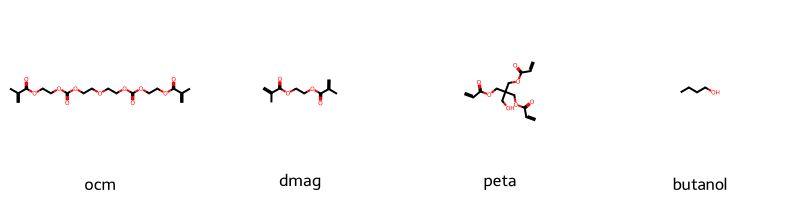

In [3]:
Draw.MolsToGridImage(
    list(RD_MOLECULES.values()),
    useSVG=True,
    molsPerRow=4,
    legends=[i.name for i in RD_MOLECULES.keys()],
)

# Traj analyse

In [190]:
# D cm2/day
def get_solve_dir(work_dir: str):
    result_dir = Path(work_dir)
    for system_sir in os.listdir(result_dir):
        for T_dir in os.listdir(result_dir / system_sir):
            yield result_dir / system_sir / T_dir


def get_MSD(u, compound: Mols):
    residue = compound.value
    selection = f'resname {residue}'
    m = msd.EinsteinMSD(u, select=selection)
    m.run()

    time = m.times * 1e-12  # ps -> s
    MSD = np.mean(m.results['msds_by_particle'], axis=1) * 1e-16  # A2 -> cm2
    return pd.DataFrame({'Time': time, residue: MSD}).fillna(0)


def get_RMSD(u, compound: Mols):
    residue = compound.value
    selection = f'resname {residue}'
    m = rms.RMSD(u, u, selection)
    m.run()
    return pd.DataFrame(m.results.rmsd[:, 1:], columns=['Time', residue])


def regress(data: pd.DataFrame):
    time, MSD = data.iloc[:, 0], data.iloc[:, 1]
    regression = linregress(time, MSD)
    D0 = regression.intercept
    D = regression.slope
    return D, D0


def strict(df: pd.DataFrame):
    slopes = []
    for i in np.arange(0, 200, 20):
        slopes.append((df.iloc[i, 0], regress(df.loc[i : i + 20])[0], i))
    slopes = np.array(slopes)

    need_slopes = slopes[(slopes[:, 1] - slopes[:, 1].mean()) / (slopes[:, 1].mean()+1e-9) < 0.2]
    # return need_slopes
    i0, i1 = need_slopes[0][2], need_slopes[-1][2]

    return df.loc[i0:i1]

In [154]:
directory = Path('tests/4MD')
compound =Mols.butanol
T = 25
pdb = Path(r'gromacs\workspace\solvs\butanol_100_700\30\box.gro')
traj = Path(r'gromacs\workspace\solvs\butanol_100_700\30\traj.xtc')

100%|██████████| 3000/3000 [00:00<00:00, 4784.67it/s]


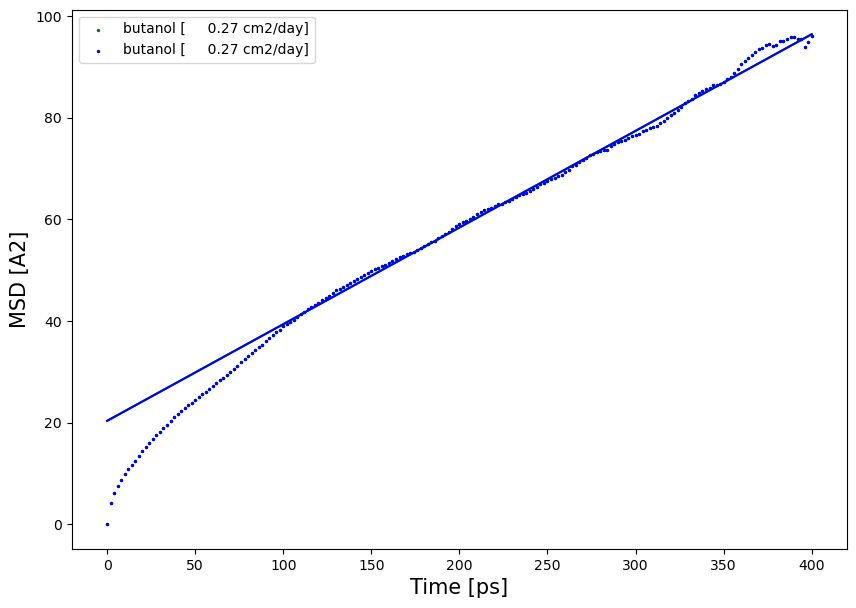

In [155]:
u = mda.Universe(pdb, traj)

x_scaller, y_scaller = 1e12,1e16
df = get_MSD(u, compound)
S, S0 = regress(strict(df))
D = S / 6 * 24 * 60 * 60


df_but = get_MSD(u, Mols.butanol)
S_but, S0_but = regress(strict(df_but))
D_but = S_but / 6 * 24 * 60 * 60


# df = strict(get_RMSD(u, compound))
# S, S0 = 0, df.iloc[:, 1].median()
# D = S0**2 * 1e12 / 1e18 / 6 * 24 * 60 * 60

# df_but = strict(get_RMSD(u, 'butanol'))
# S_but, S0_but = 0, df_but.iloc[:, 1].median()
# D_but = S0_but**2 * 1e12 / 1e18 / 6 * 24 * 60 * 60

fig, ax = plt.subplots()
ax.set_ylabel('MSD [A2]')
ax.set_xlabel('Time [ps]')

time = df['Time']

ax.scatter(
    time * x_scaller,
    df.iloc[:, 1] * y_scaller,
    label=f'{compound.name:7} [{D: 9.2f} cm2/day]',
    c='g',
    s=2,
)

time_but = df_but['Time']
ax.plot(time * x_scaller, (S * time + S0) * y_scaller, 'g')
ax.scatter(
    time_but * x_scaller,
    df_but.iloc[:, 1] * y_scaller,
    label=f'butanol [{D_but: 9.2f} cm2/day]',
    c='b',
    s=2,
)
ax.plot(time_but * x_scaller, (S_but * time_but + S0_but) * y_scaller, 'b-')
ax.legend()

# ax.set_title(f"{compound} - {x} butanol :{T} C")
# fig.savefig(f"MSD_old.jpg", dpi=600)

In [208]:
# solves_path =r'gromacs\workspace\solvs'
# plots_path = r'gromacs\workspace\MSD_plots'

# pdb_name ='box.gro'
# traj_name= 'traj.xtc'


solves_path =r'openmm\workspace\results'
plots_path = r'openmm\workspace\MSD_plots'

pdb_name ='Eq.pdb'
traj_name= 'traj.xtc'

100%|██████████| 2800/2800 [00:00<00:00, 3457.95it/s]
0it [00:00, ?it/s]
100%|██████████| 2800/2800 [00:00<00:00, 3156.79it/s]
0it [00:00, ?it/s]
100%|██████████| 2800/2800 [00:00<00:00, 3448.34it/s]
0it [00:00, ?it/s]
100%|██████████| 2800/2800 [00:00<00:00, 3522.03it/s]
0it [00:00, ?it/s]
100%|██████████| 2800/2800 [00:00<00:00, 3530.99it/s]
0it [00:00, ?it/s]
100%|██████████| 5500/5500 [00:01<00:00, 3526.37it/s]
0it [00:00, ?it/s]
100%|██████████| 5500/5500 [00:01<00:00, 3404.05it/s]
0it [00:00, ?it/s]
100%|██████████| 5500/5500 [00:01<00:00, 3244.83it/s]
0it [00:00, ?it/s]
100%|██████████| 5500/5500 [00:01<00:00, 3433.98it/s]
0it [00:00, ?it/s]
100%|██████████| 5500/5500 [00:01<00:00, 3501.59it/s]
0it [00:00, ?it/s]
100%|██████████| 660/660 [00:00<00:00, 3235.29it/s]


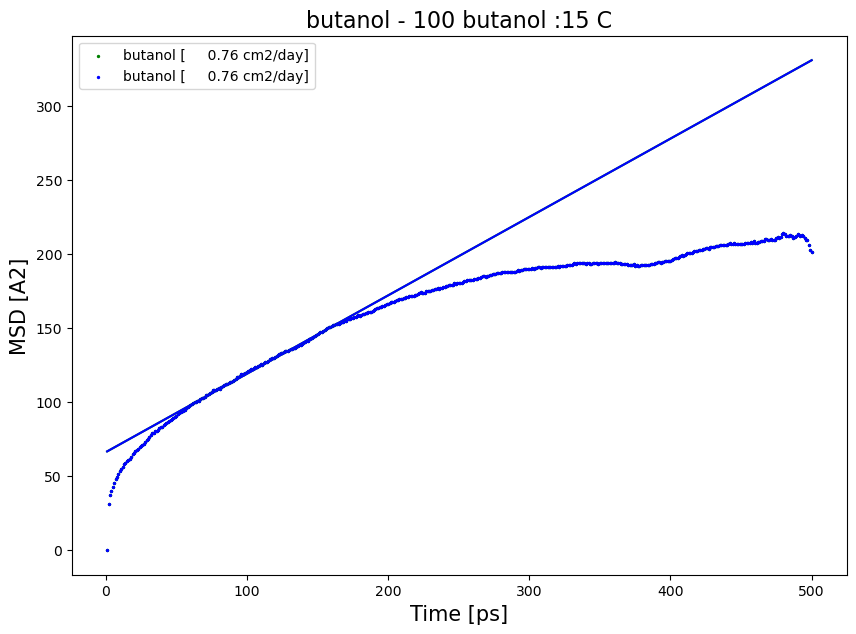

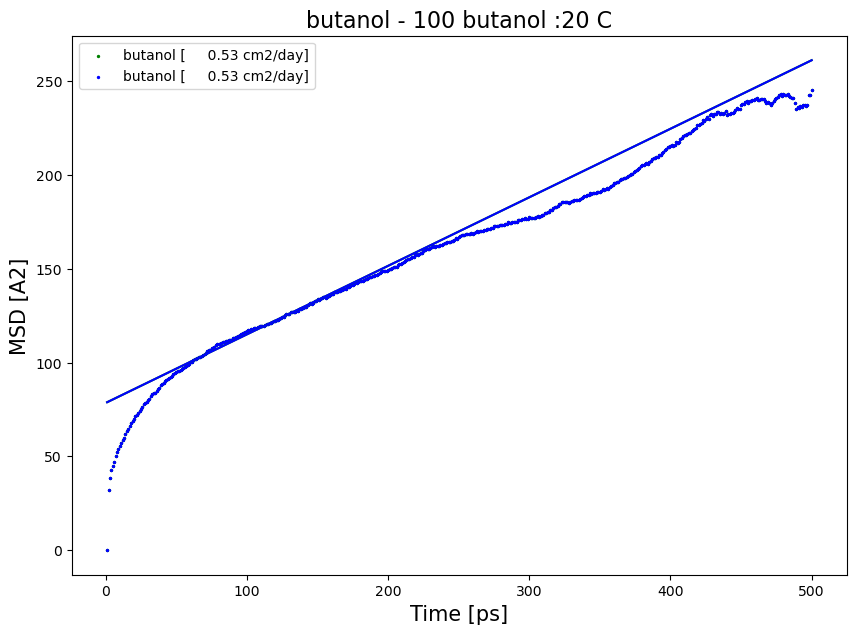

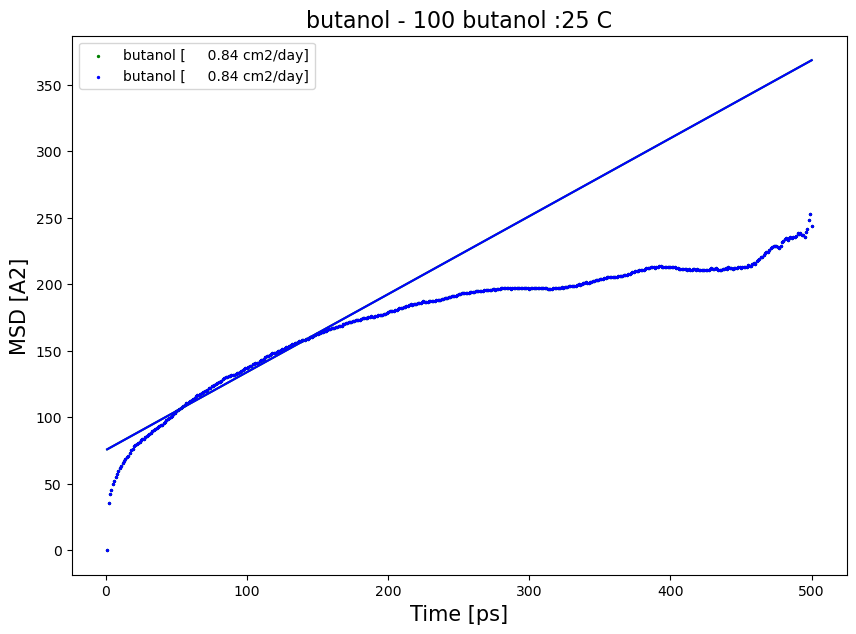

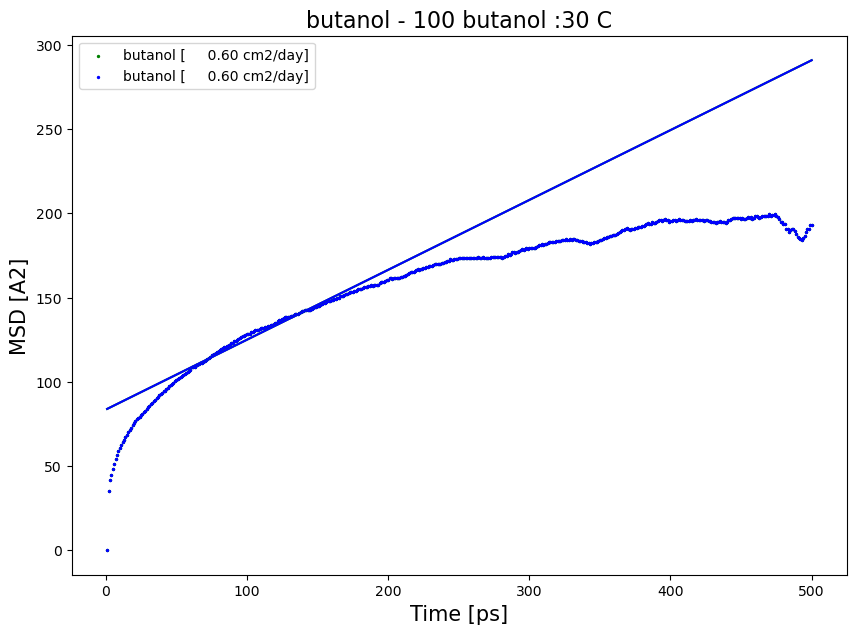

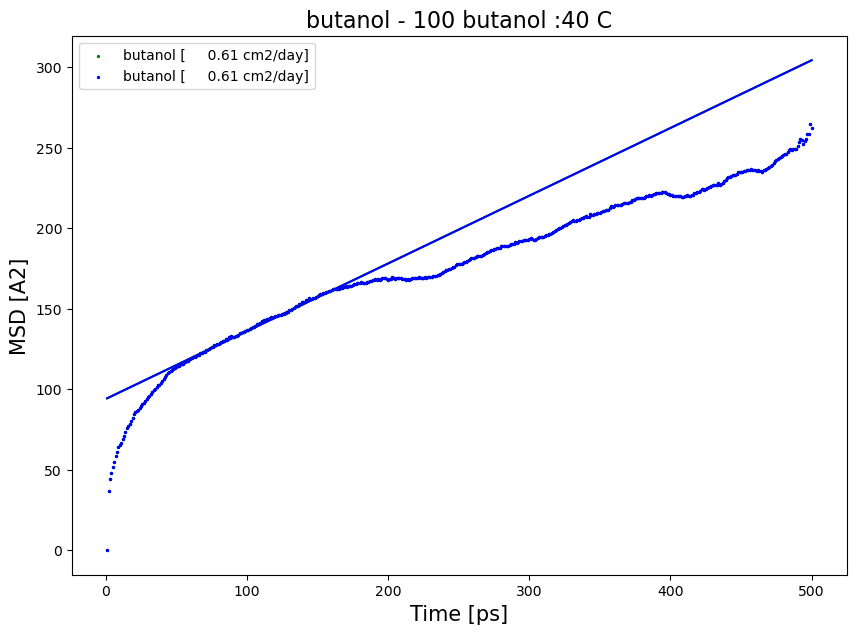

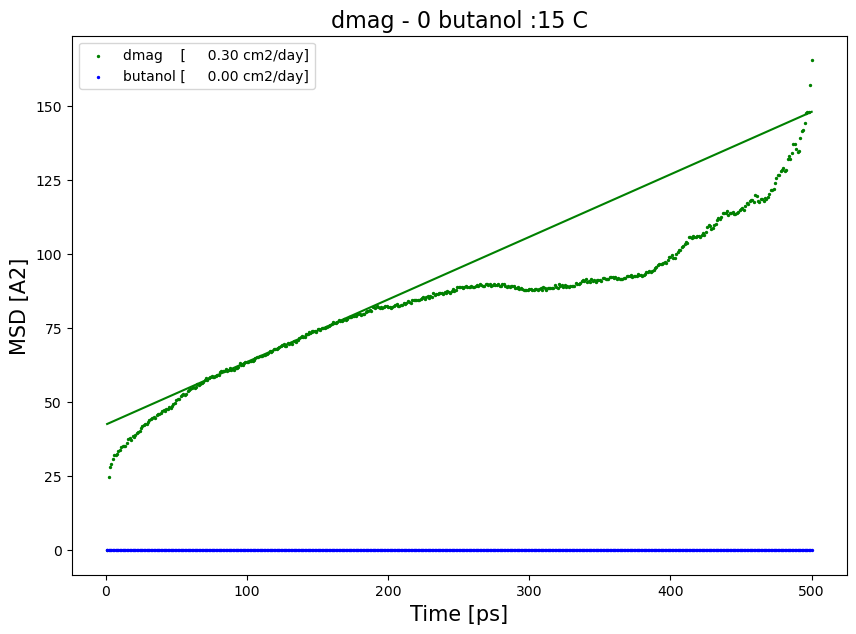

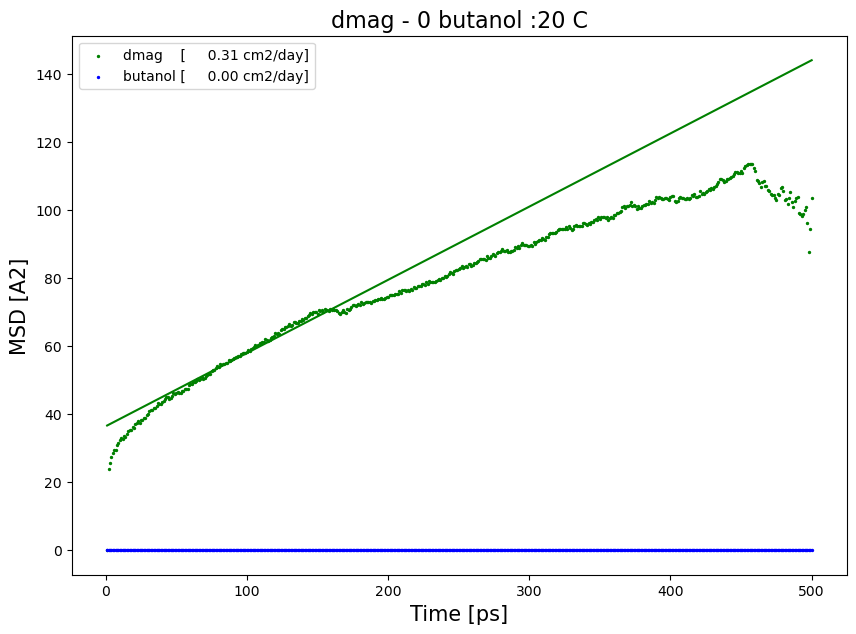

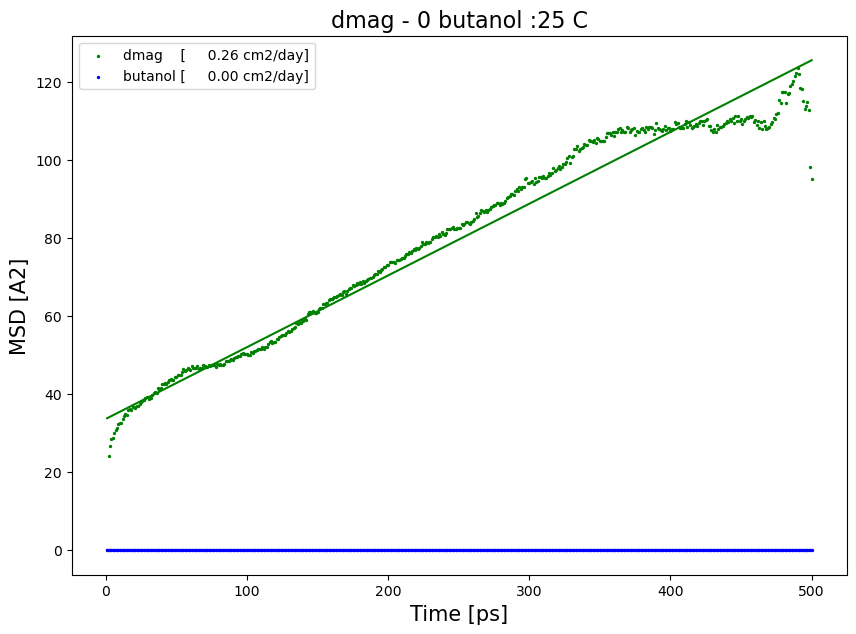

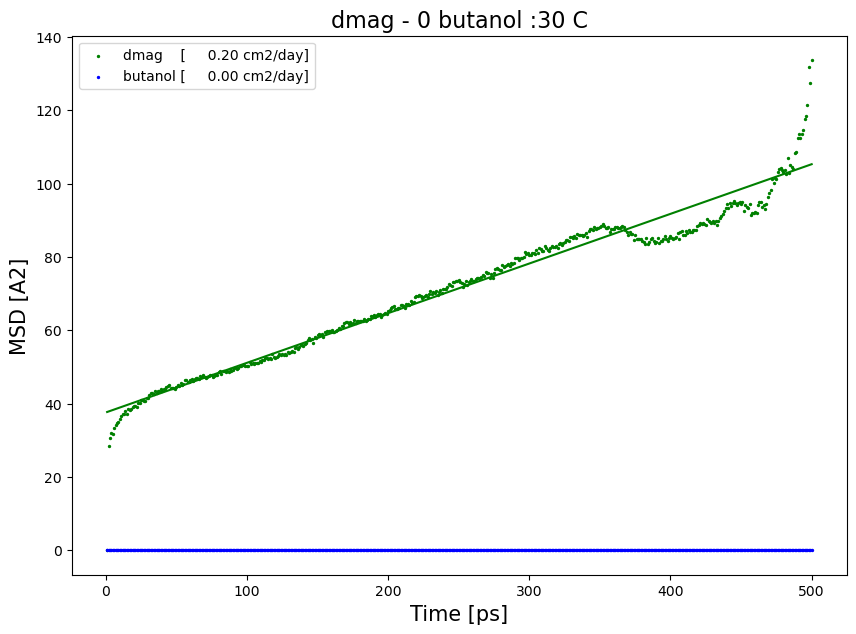

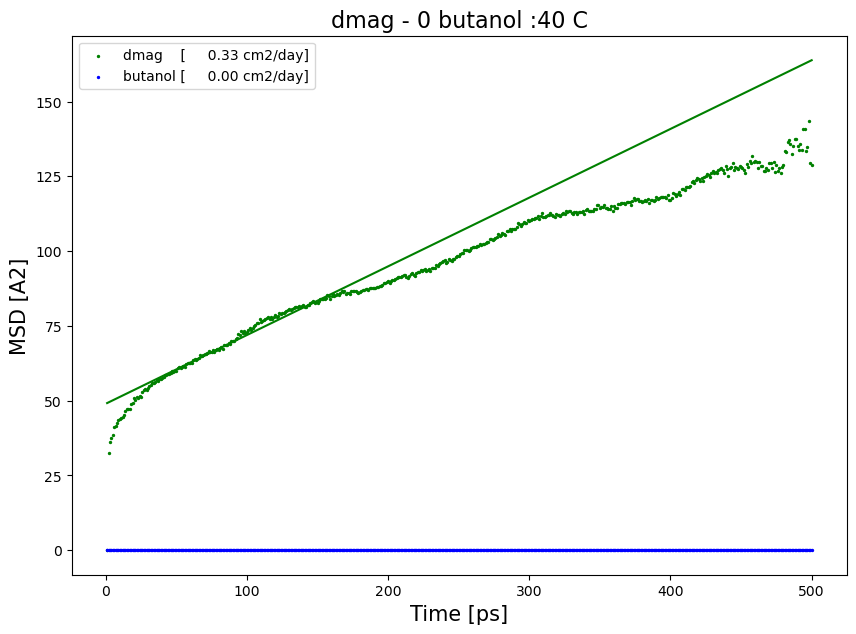

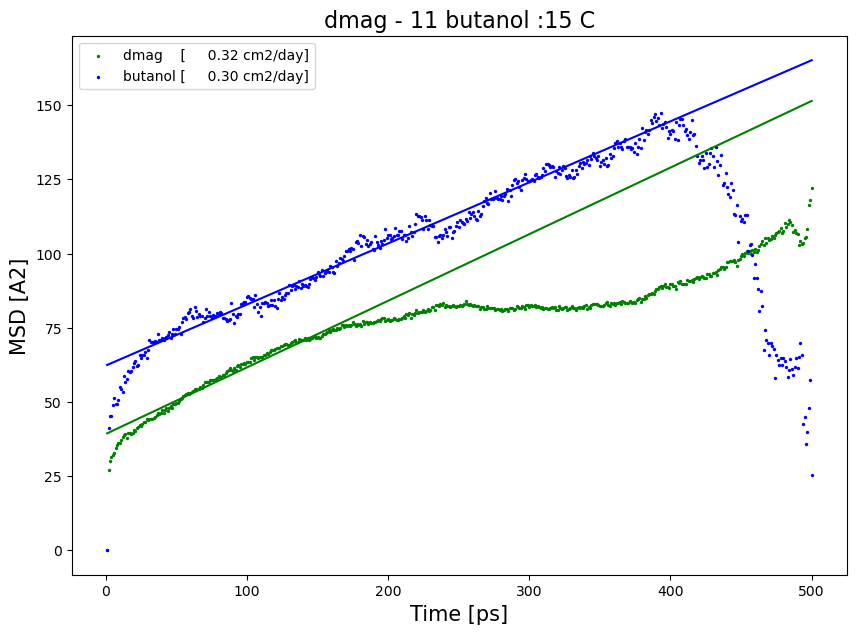

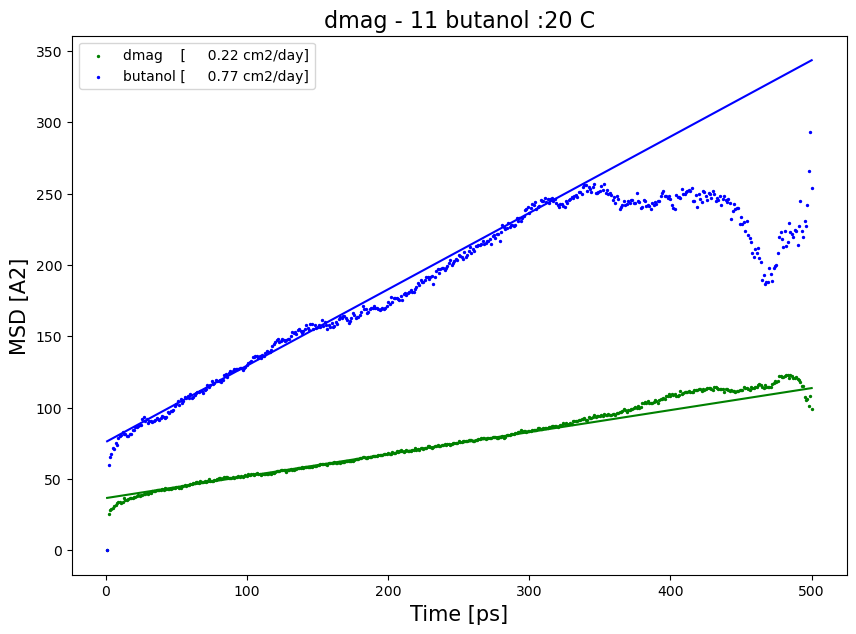

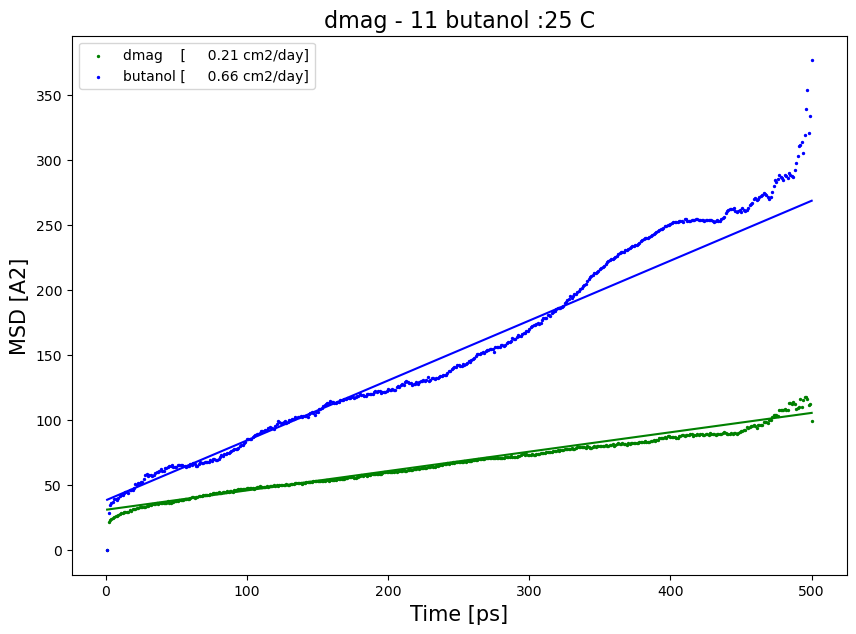

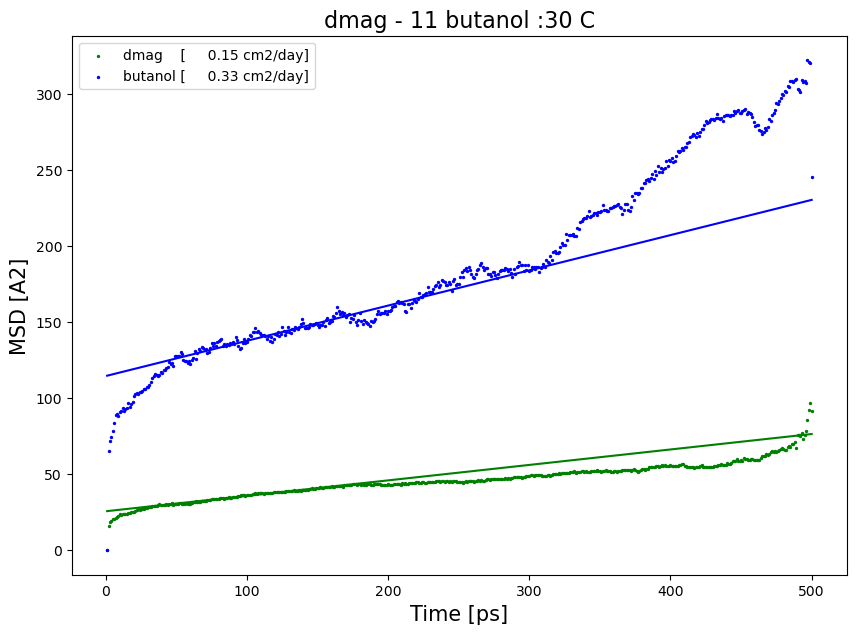

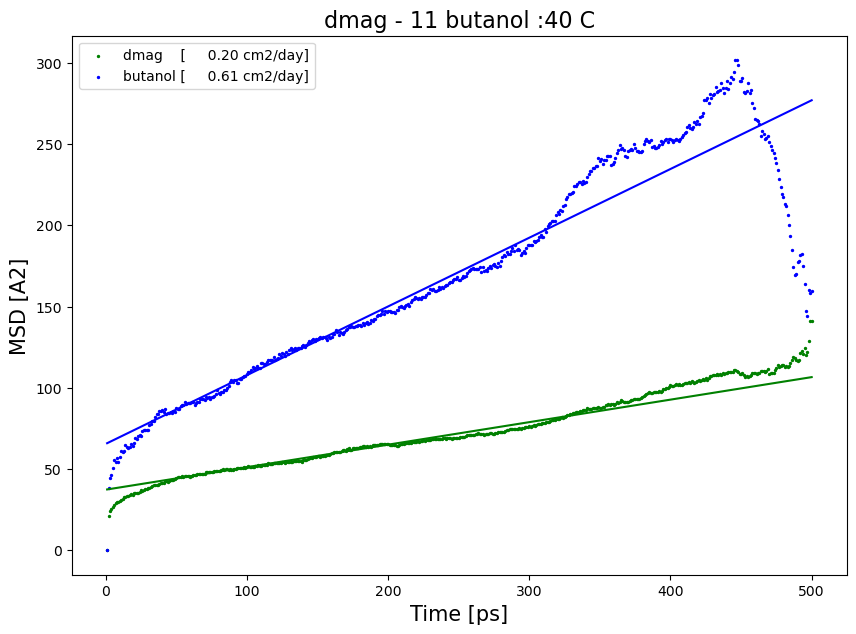

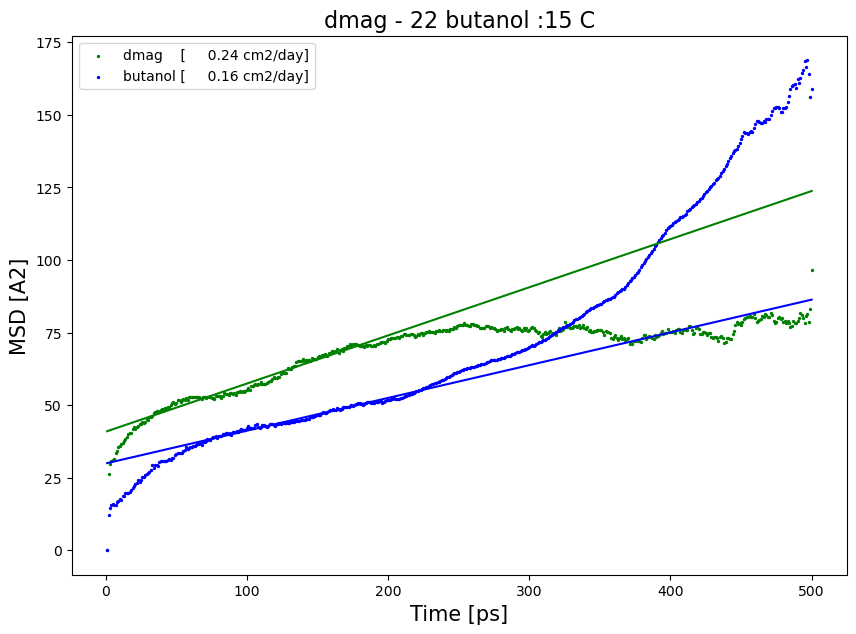

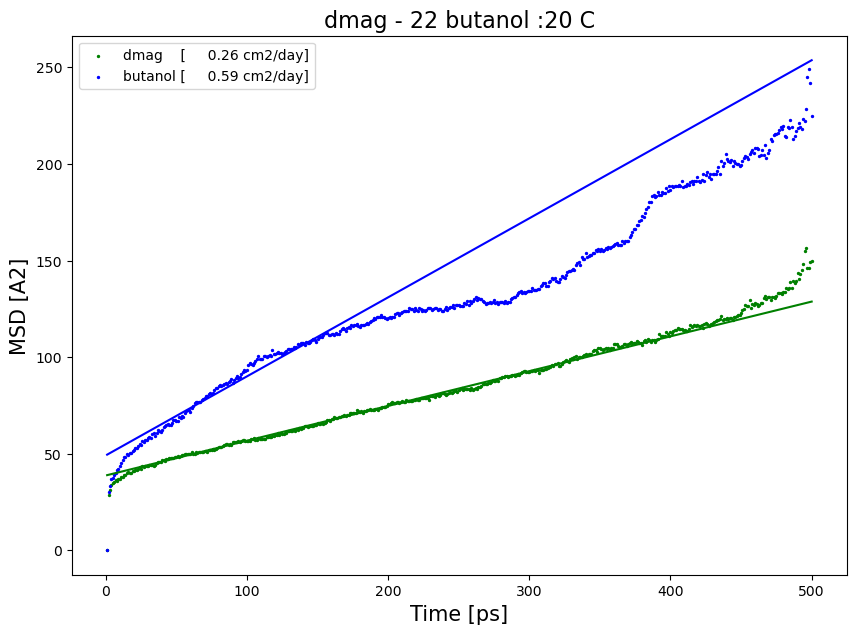

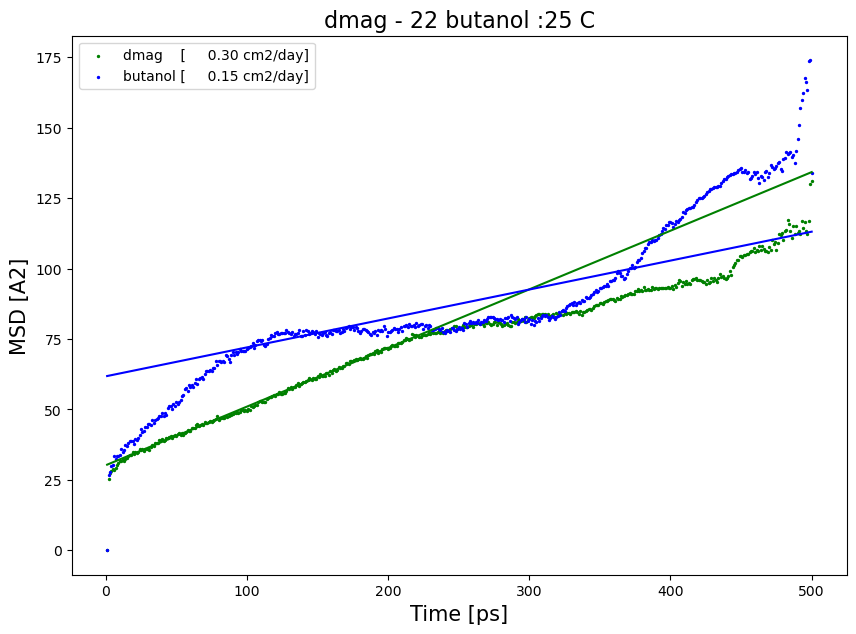

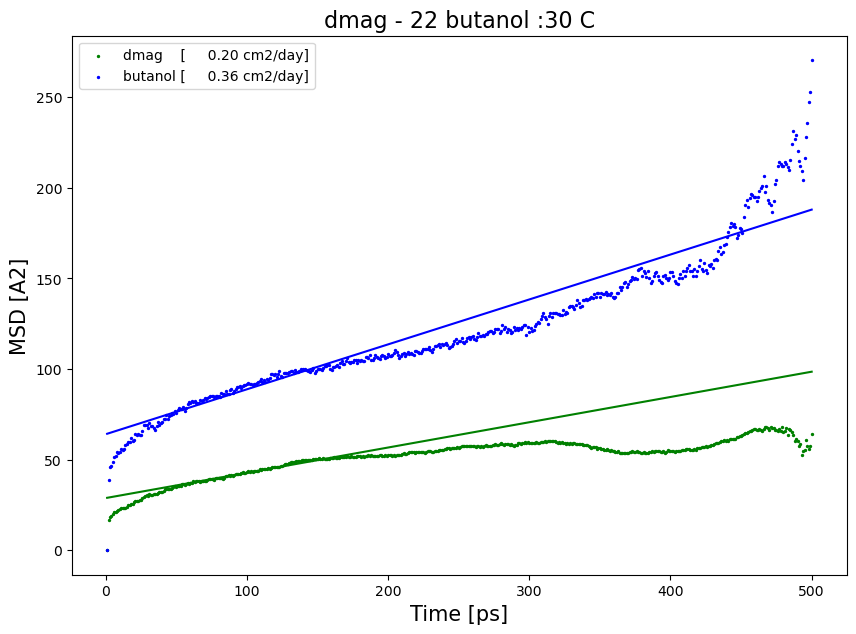

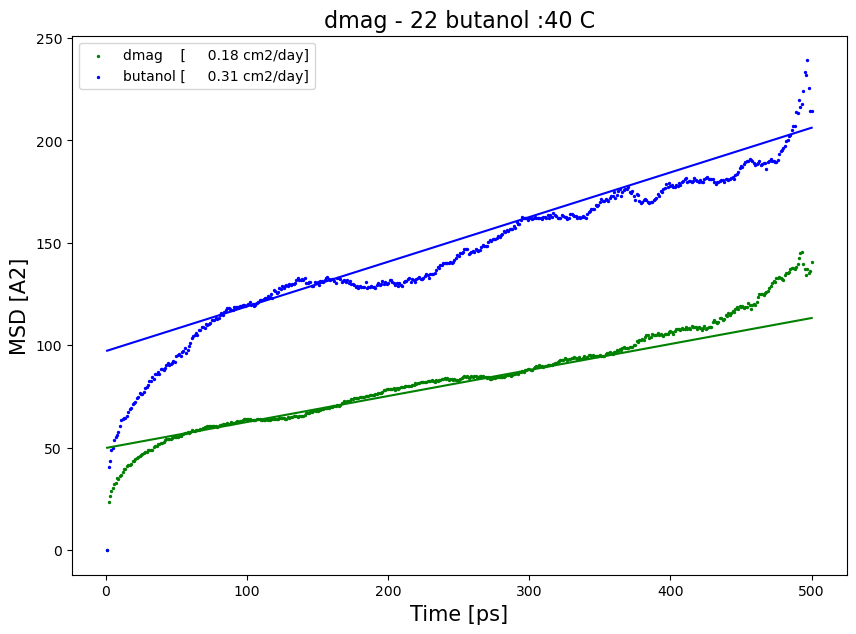

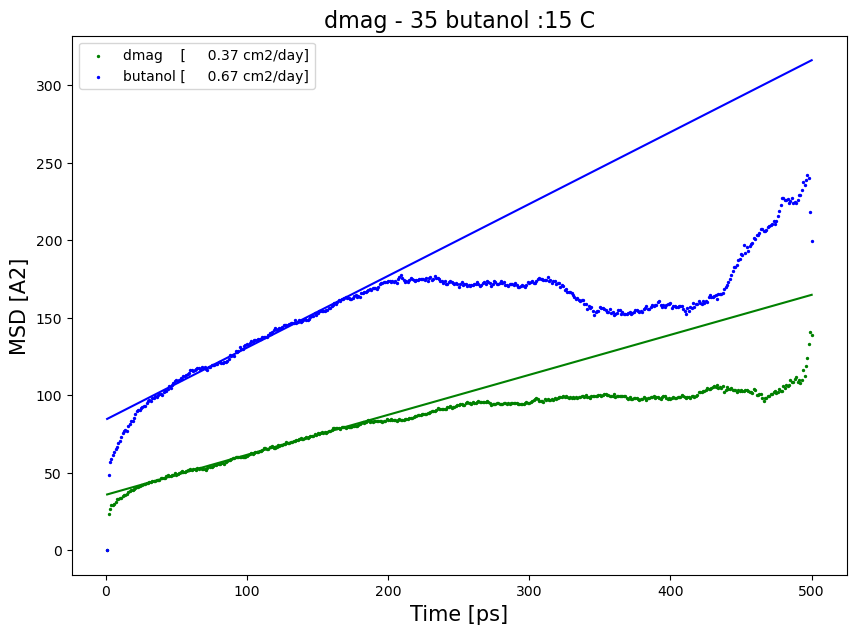

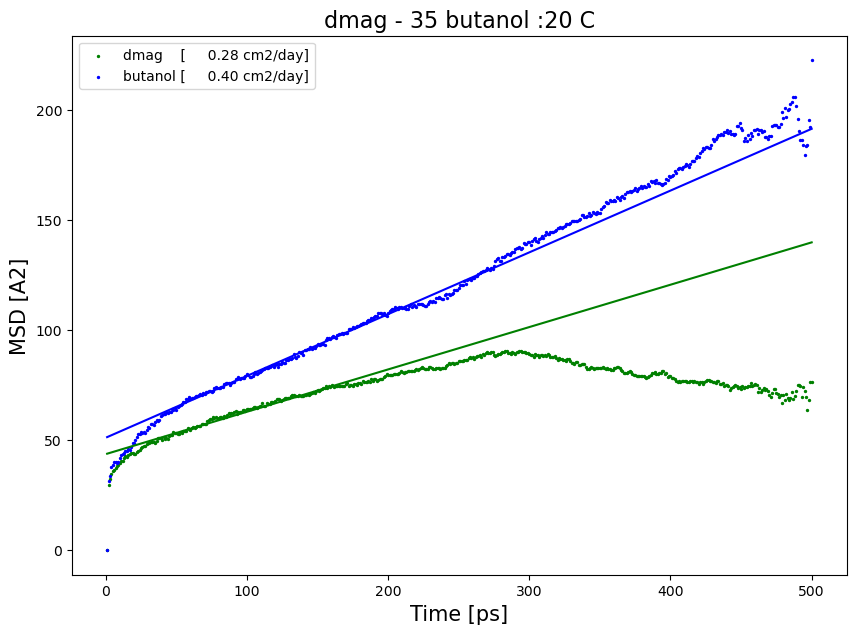

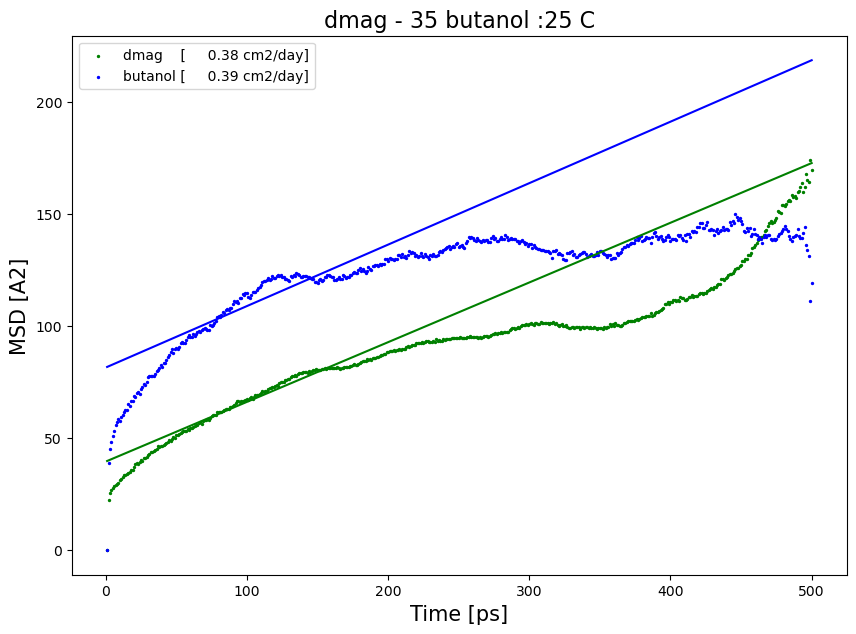

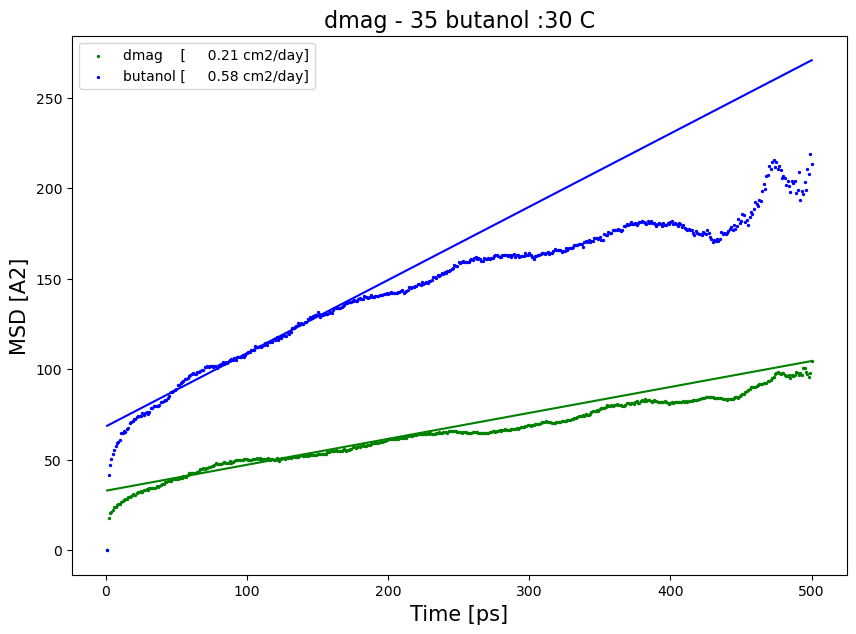

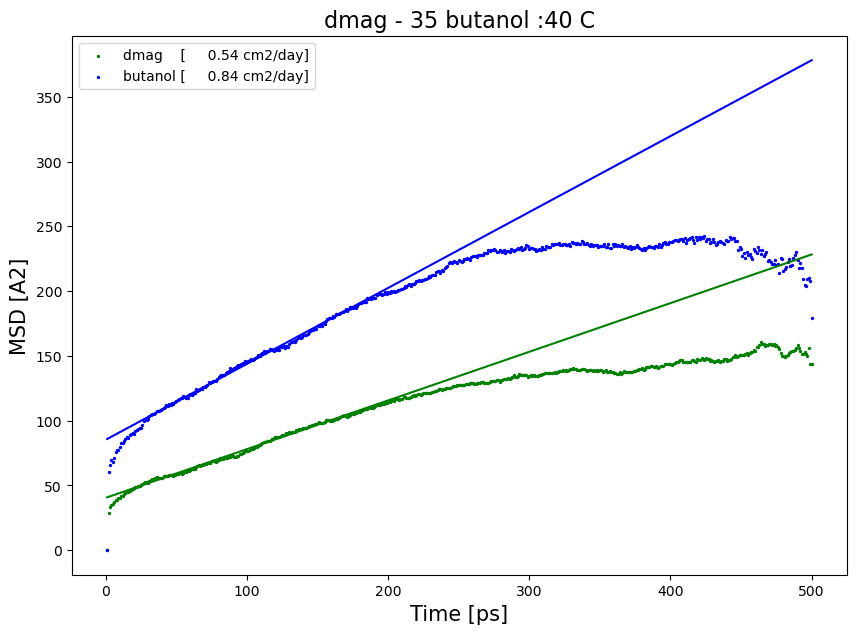

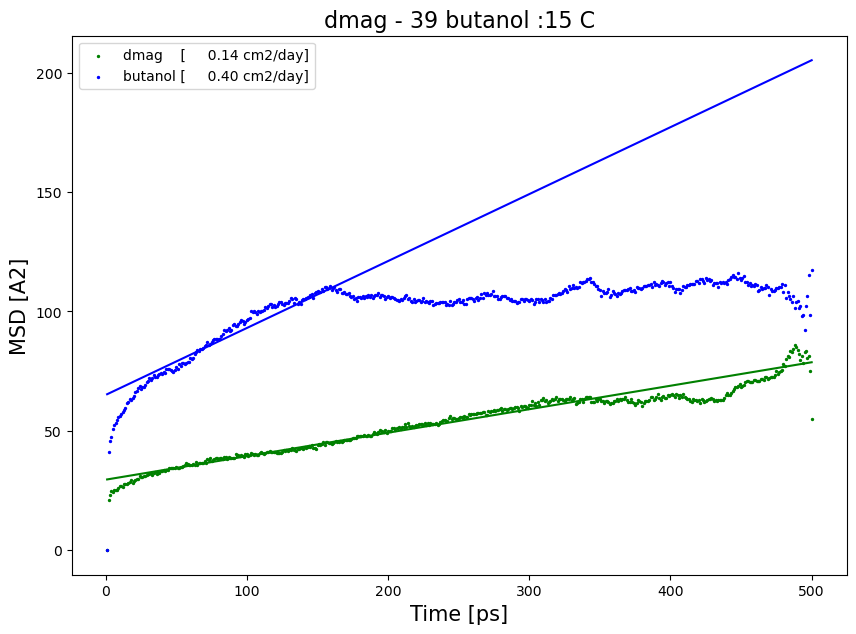

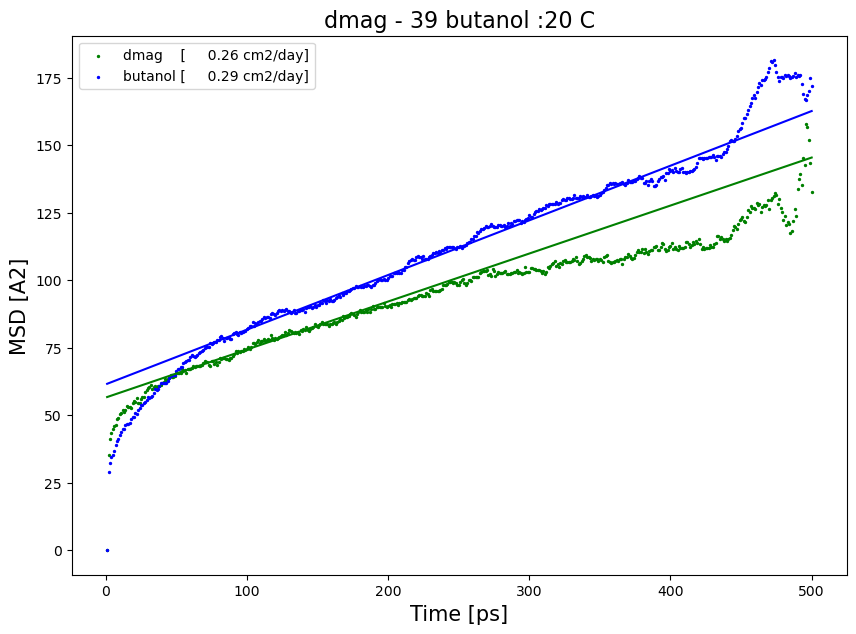

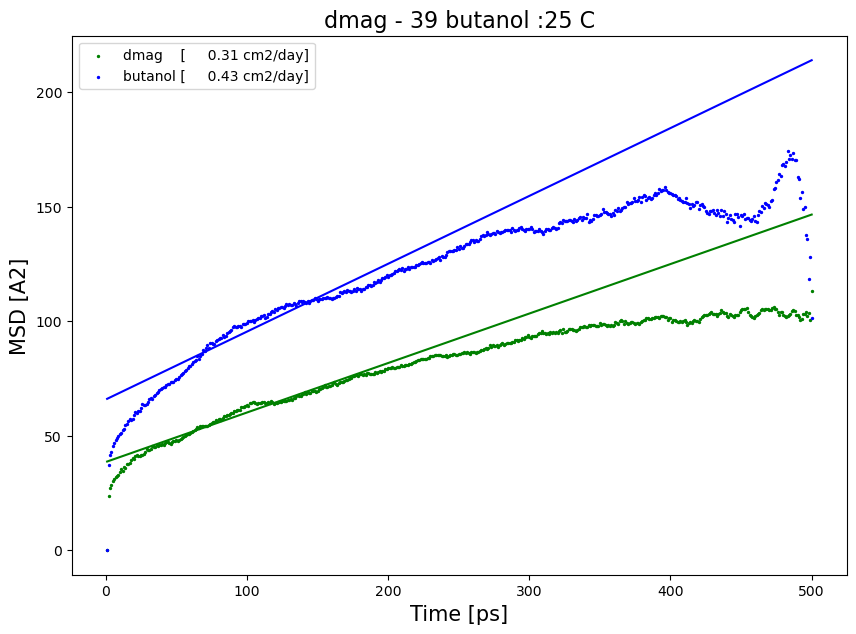

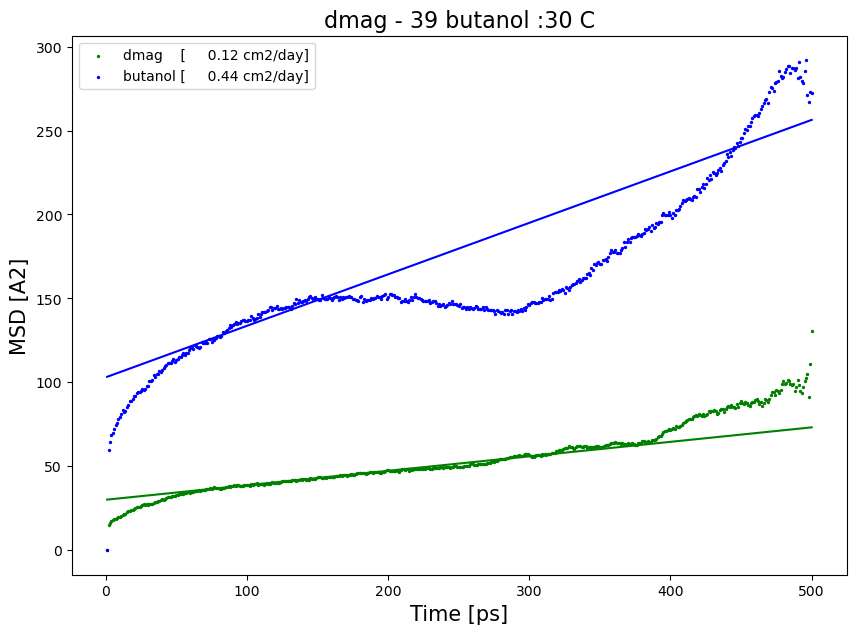

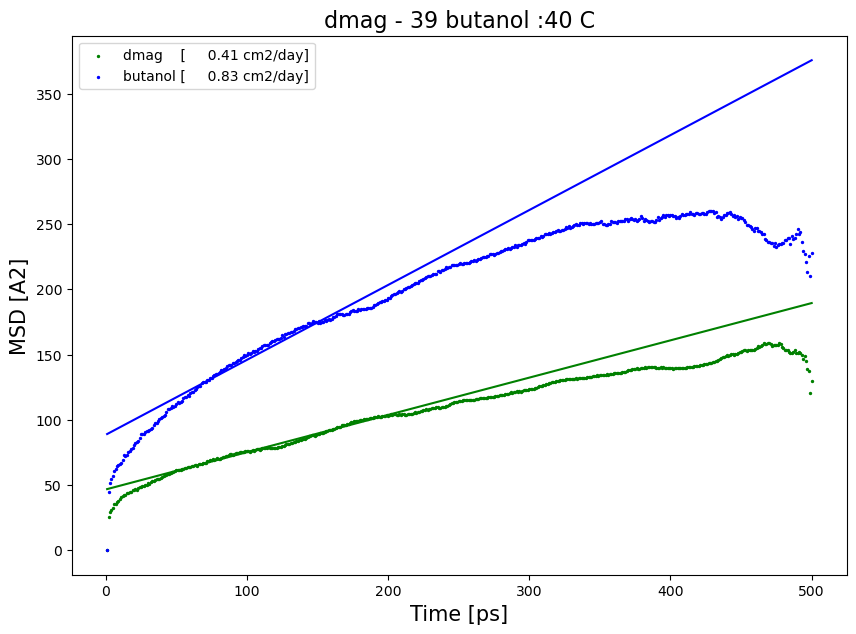

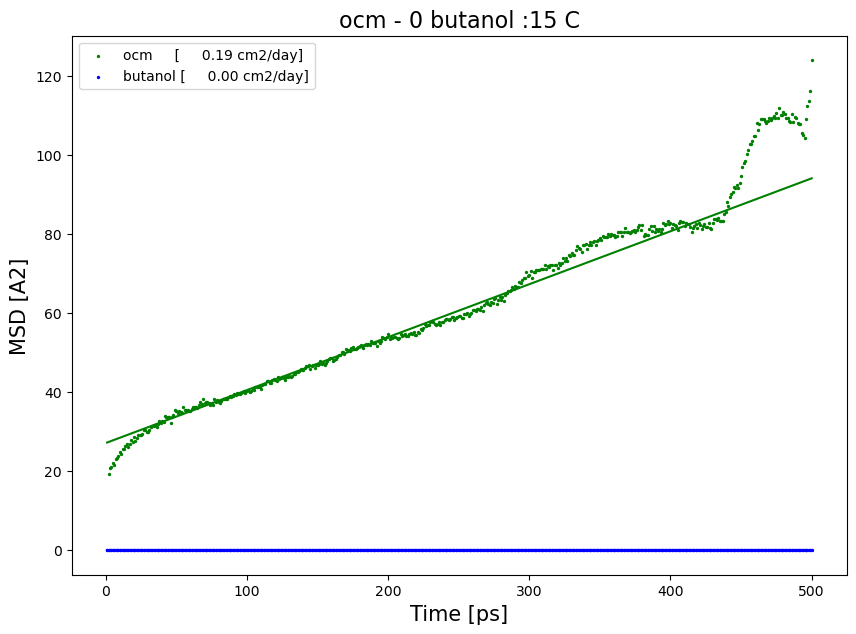

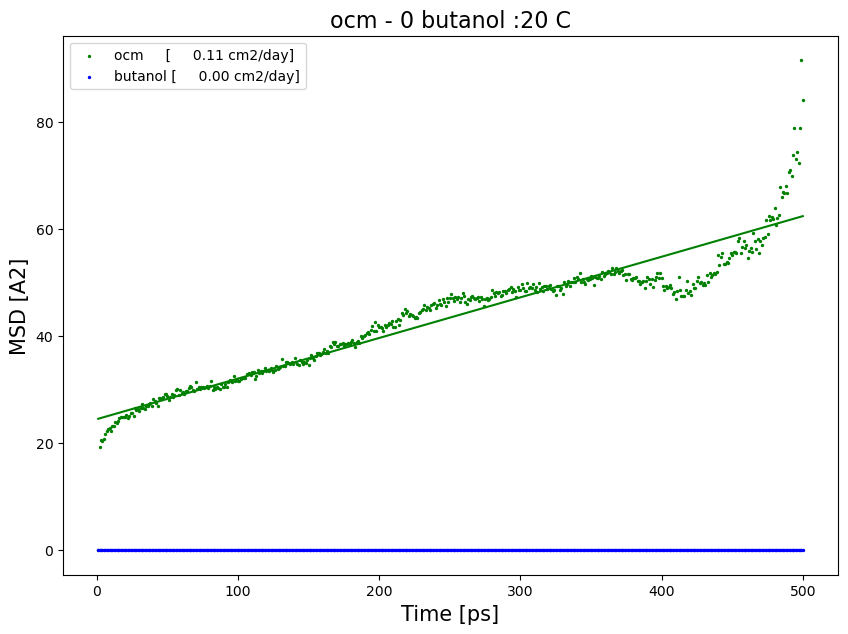

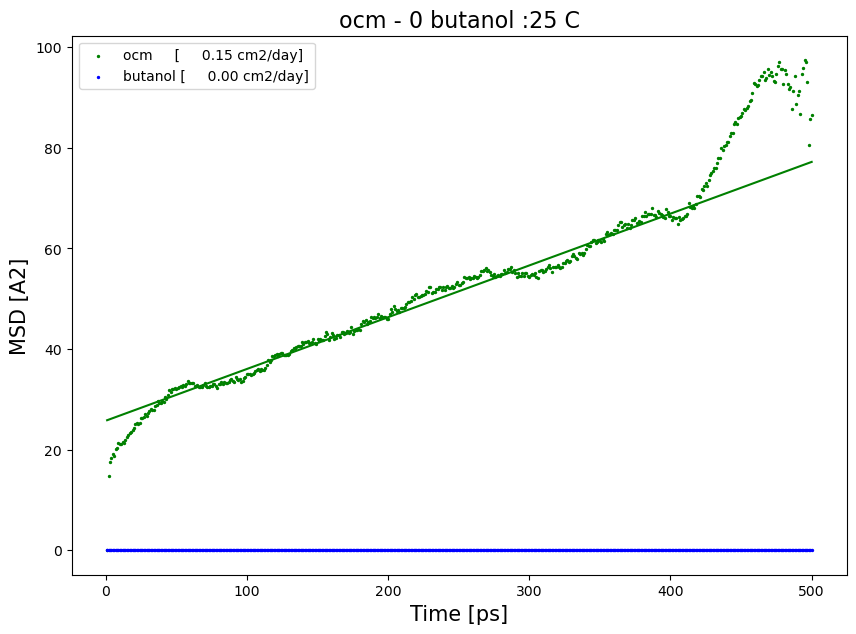

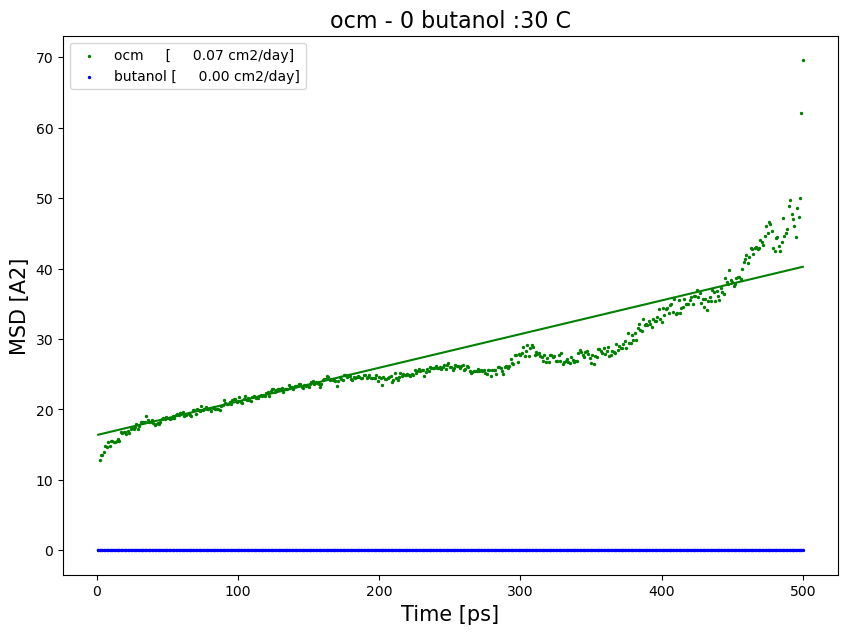

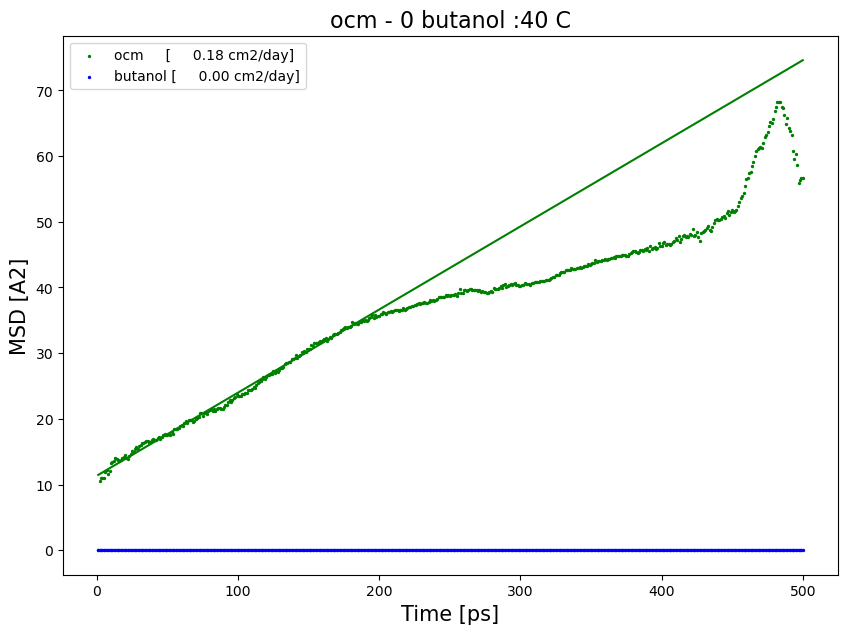

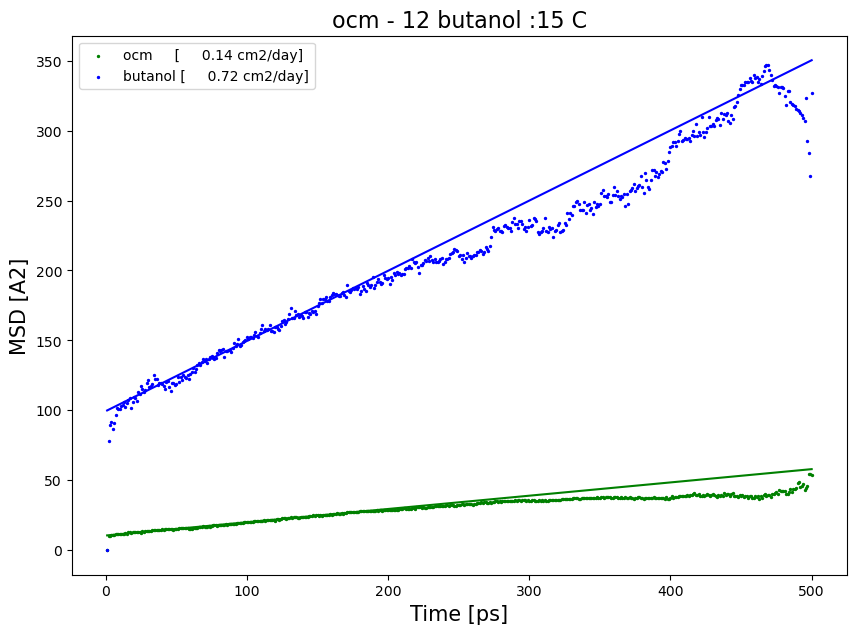

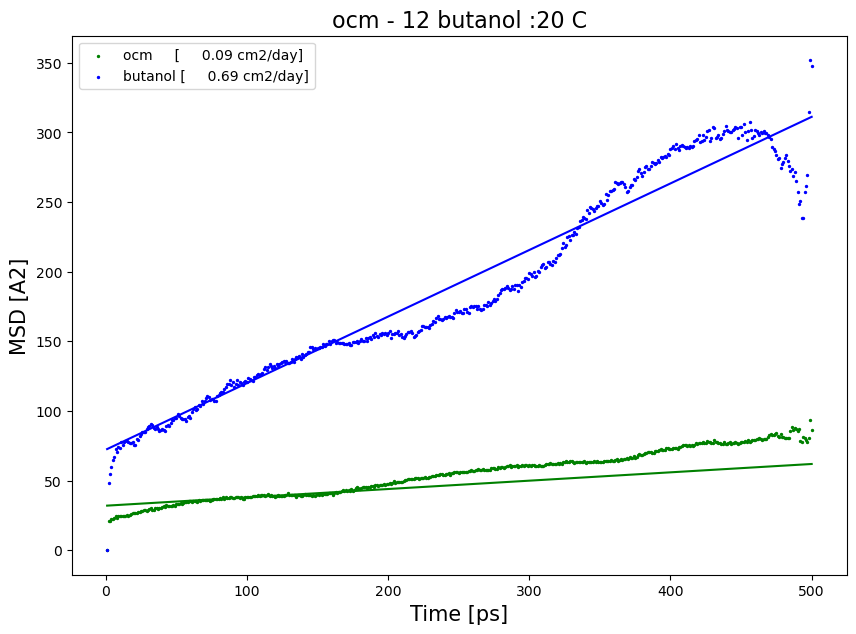

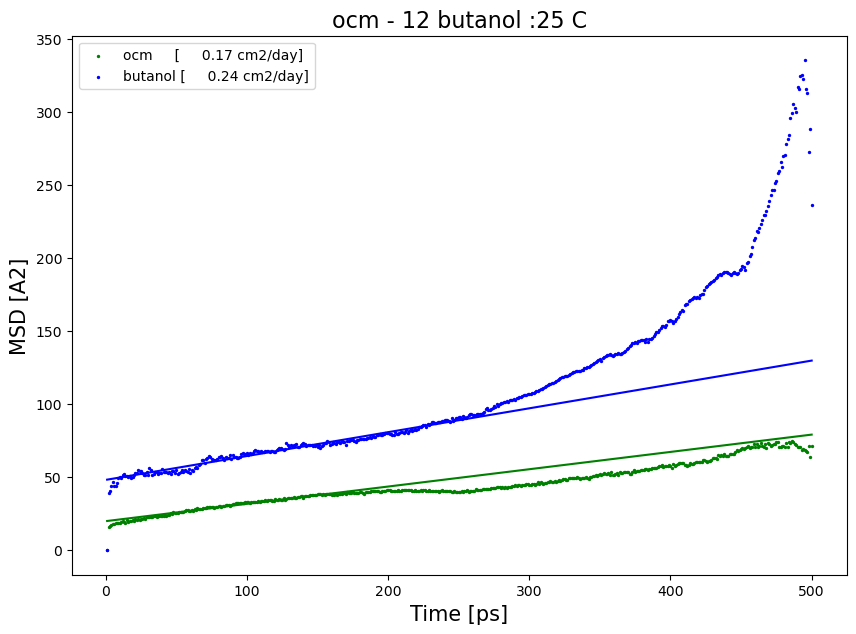

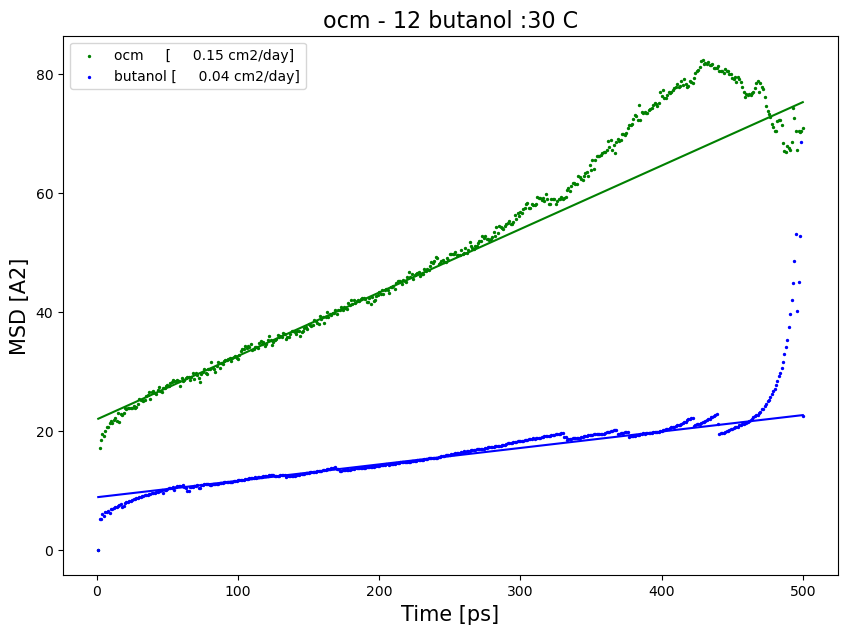

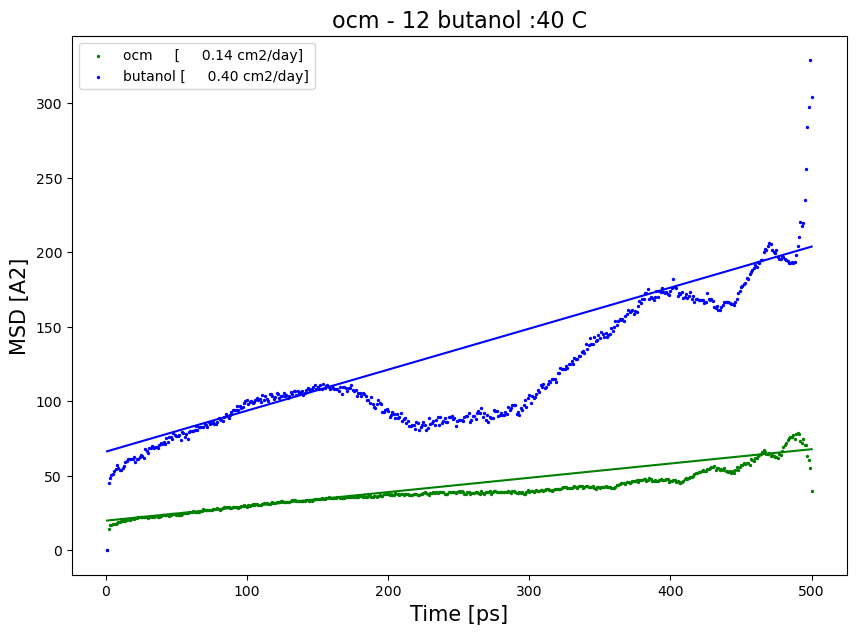

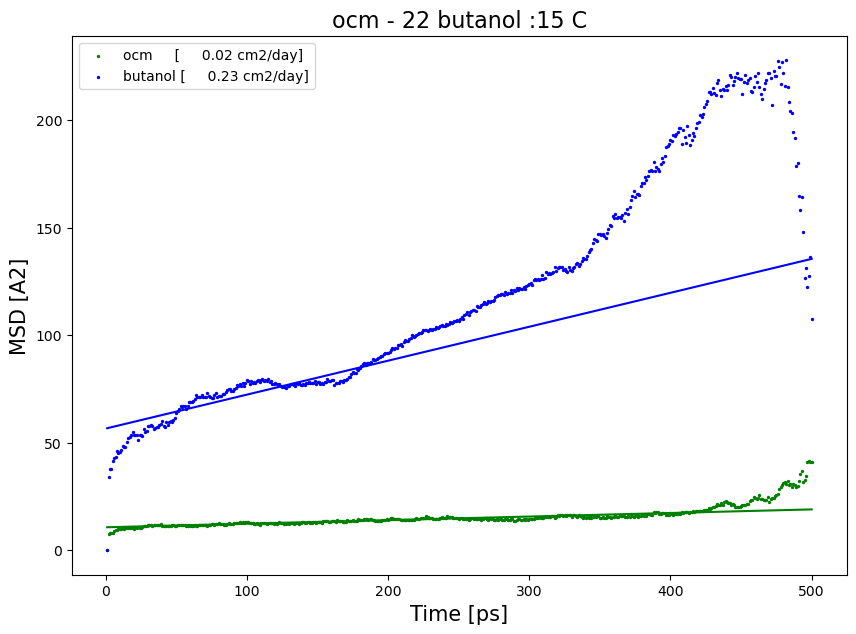

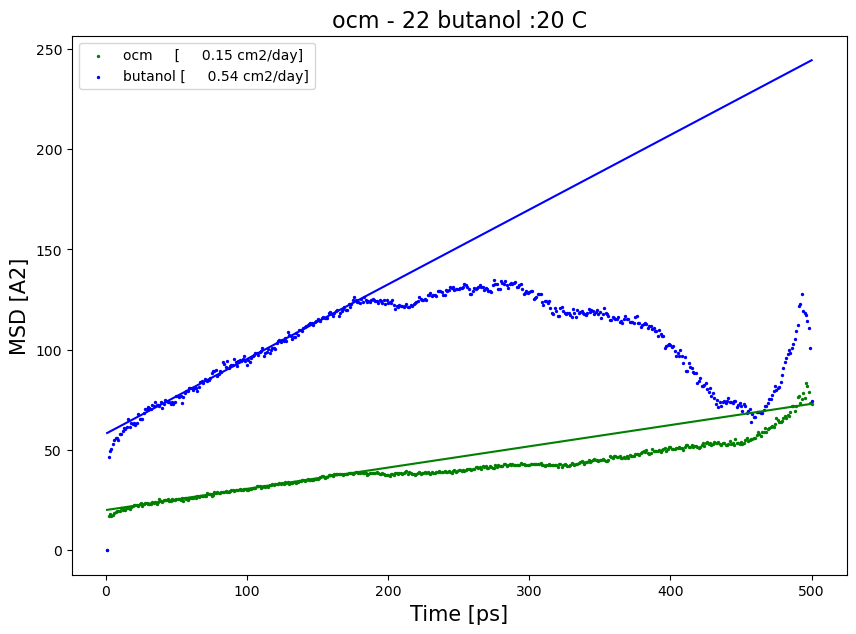

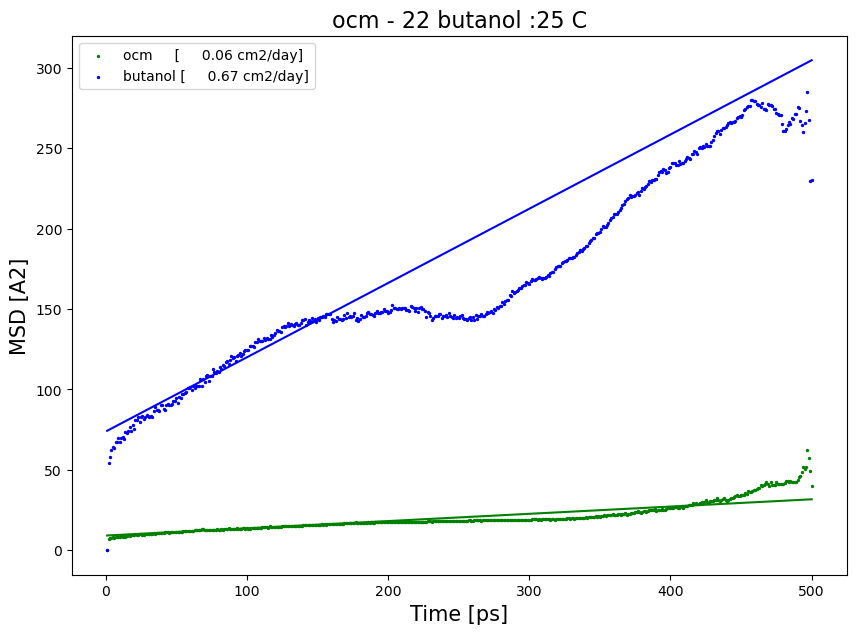

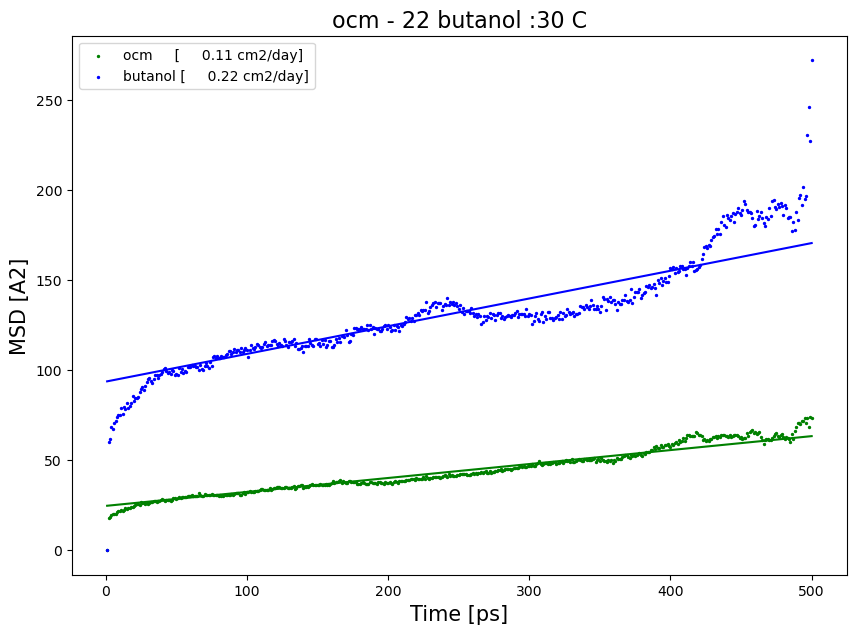

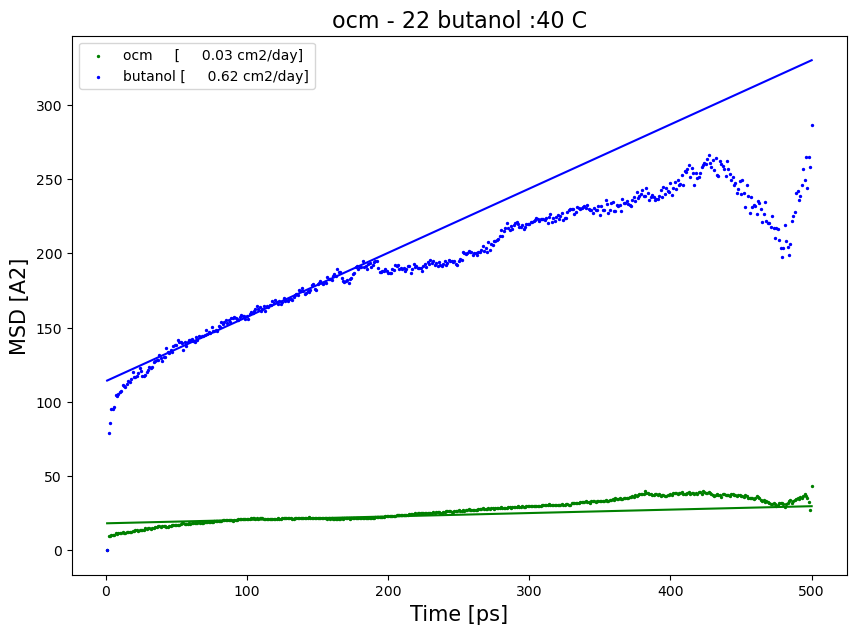

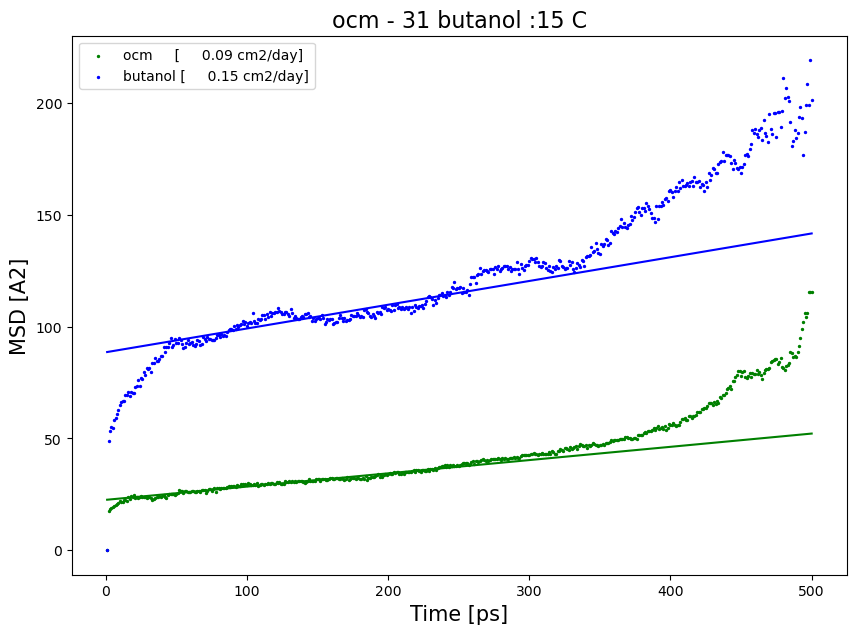

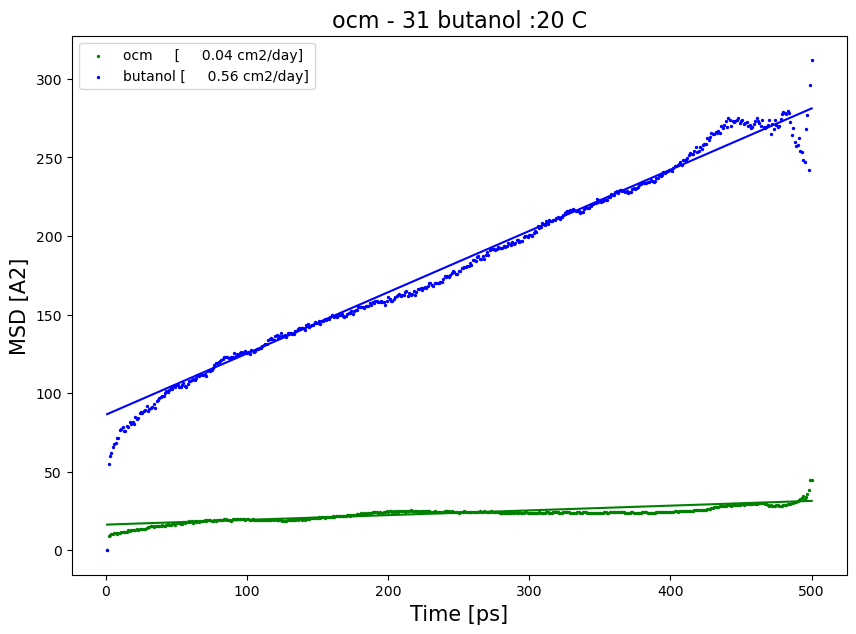

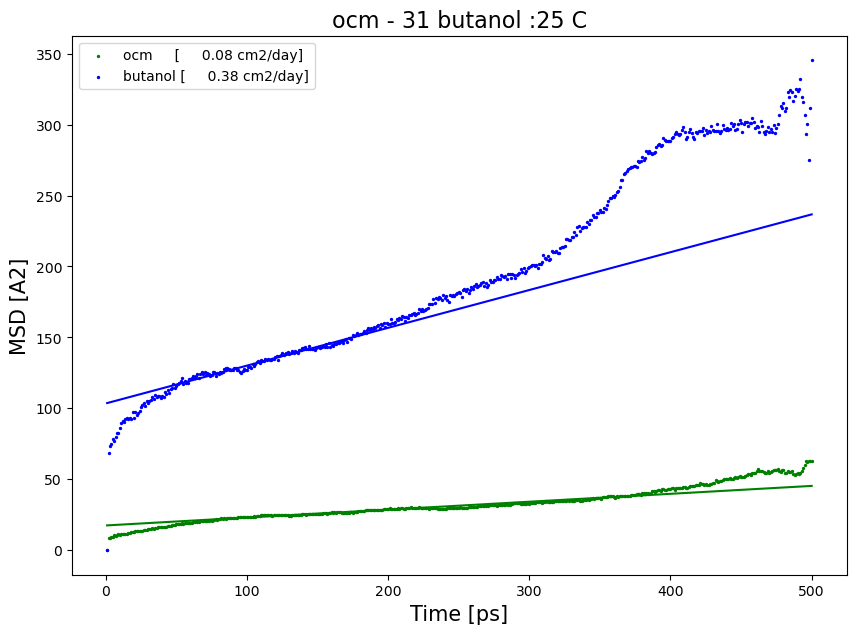

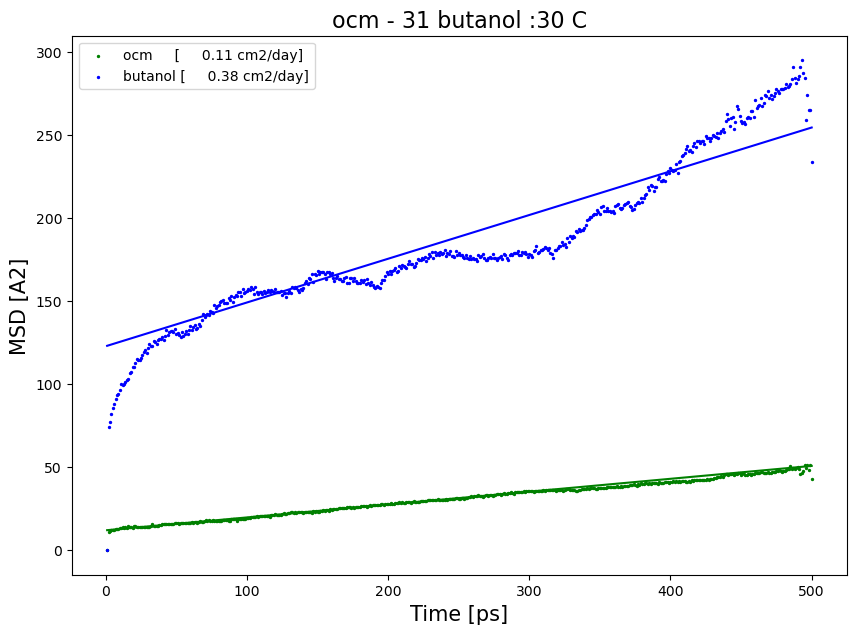

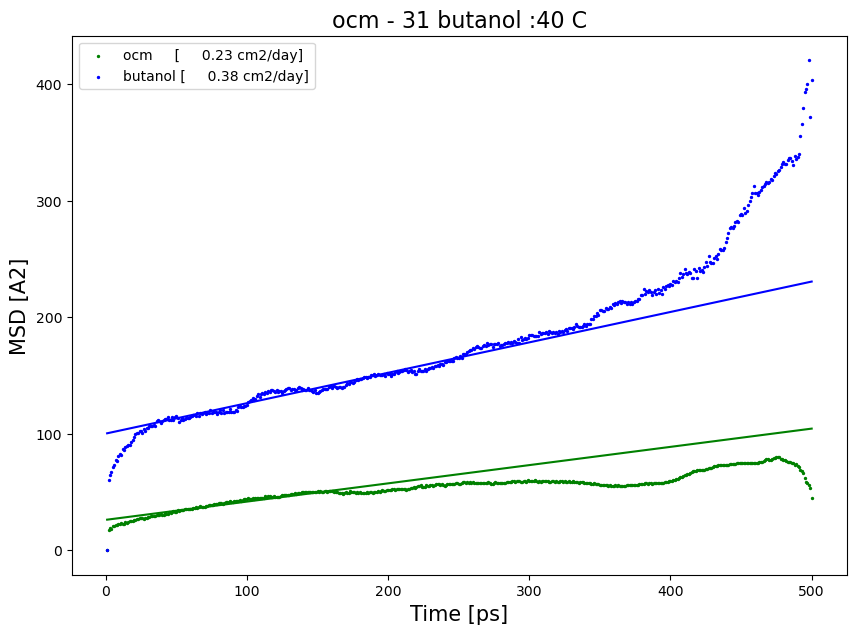

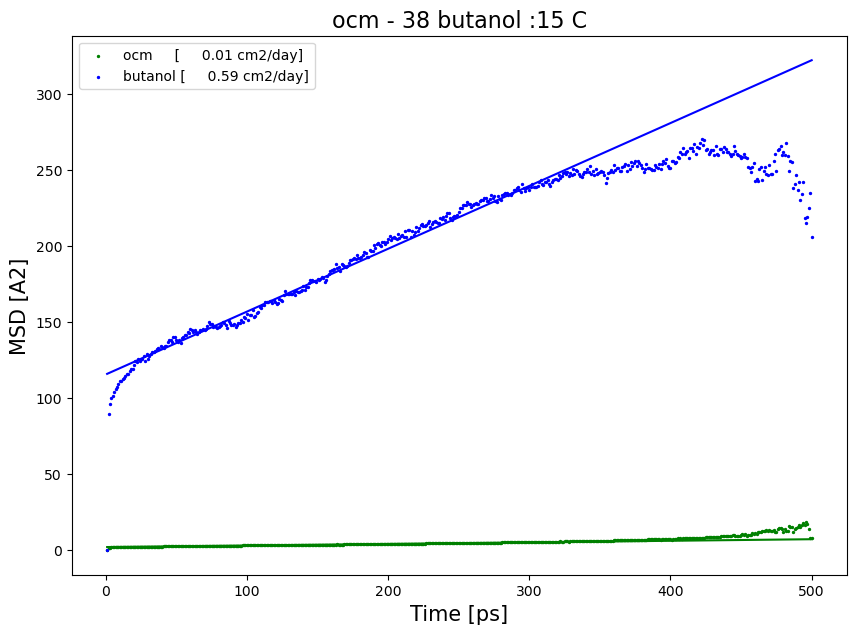

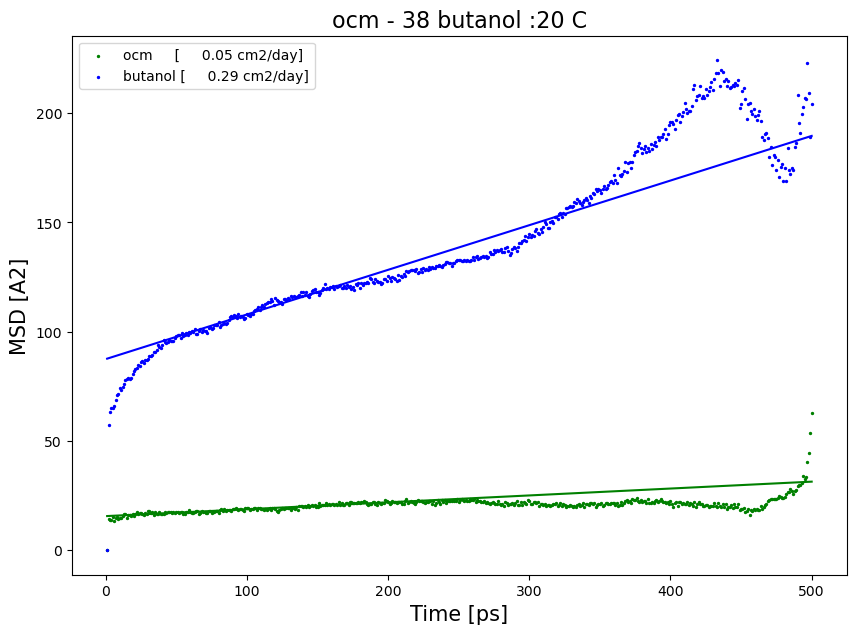

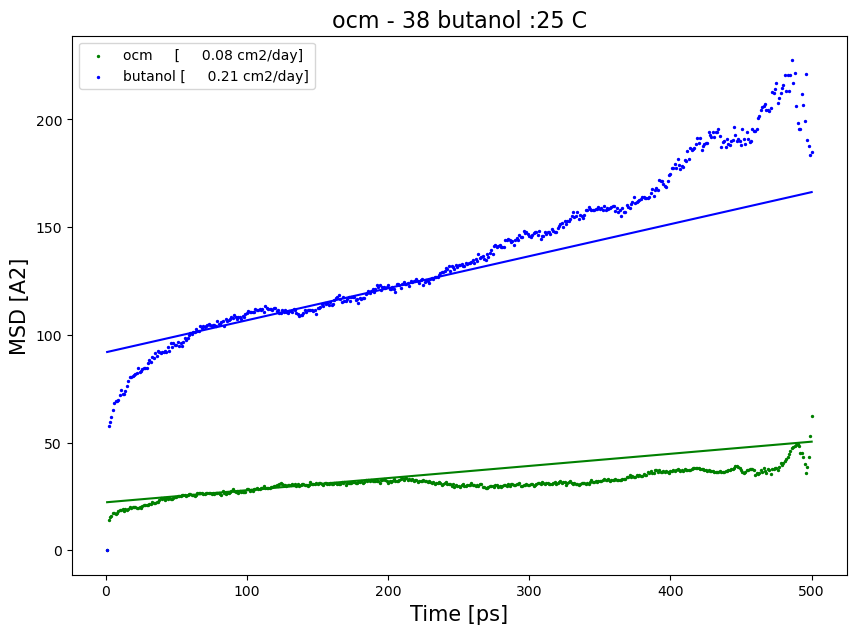

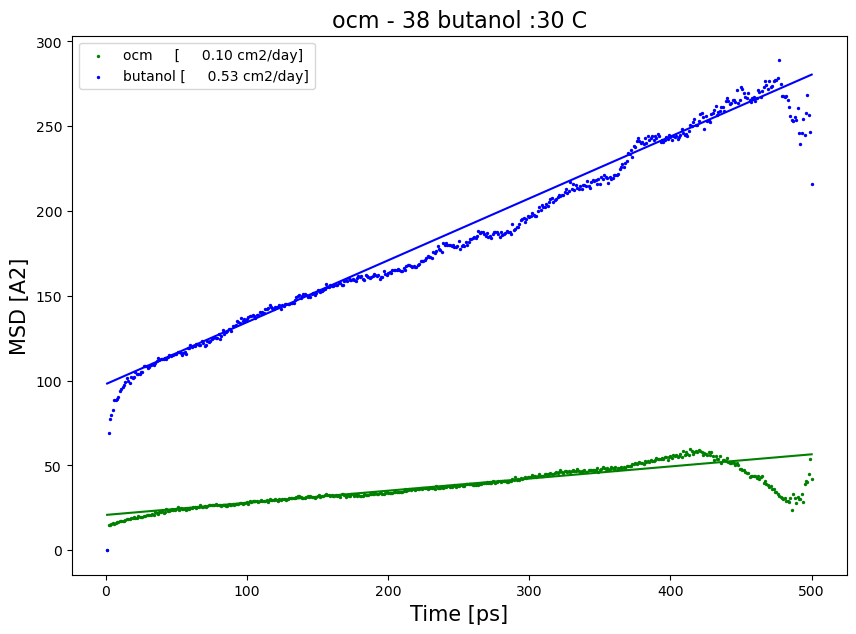

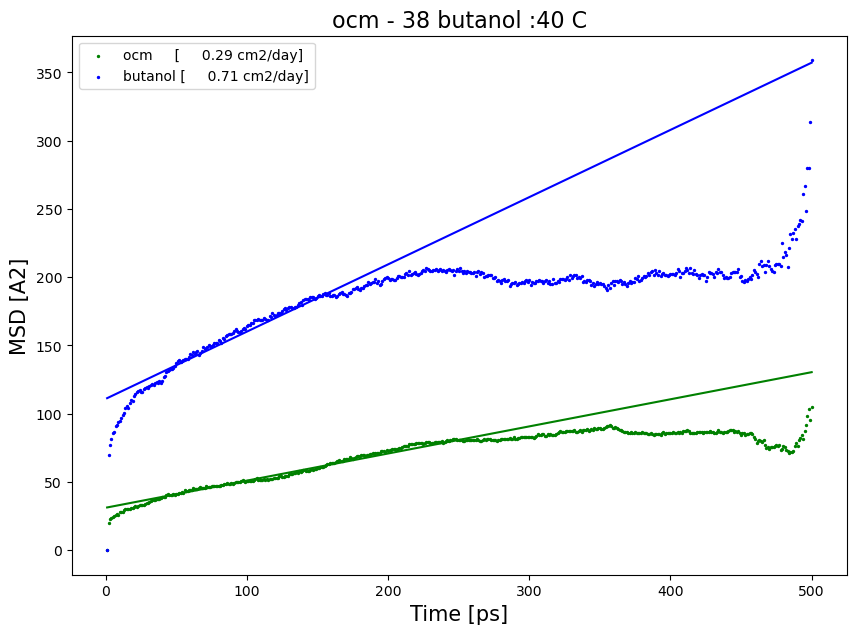

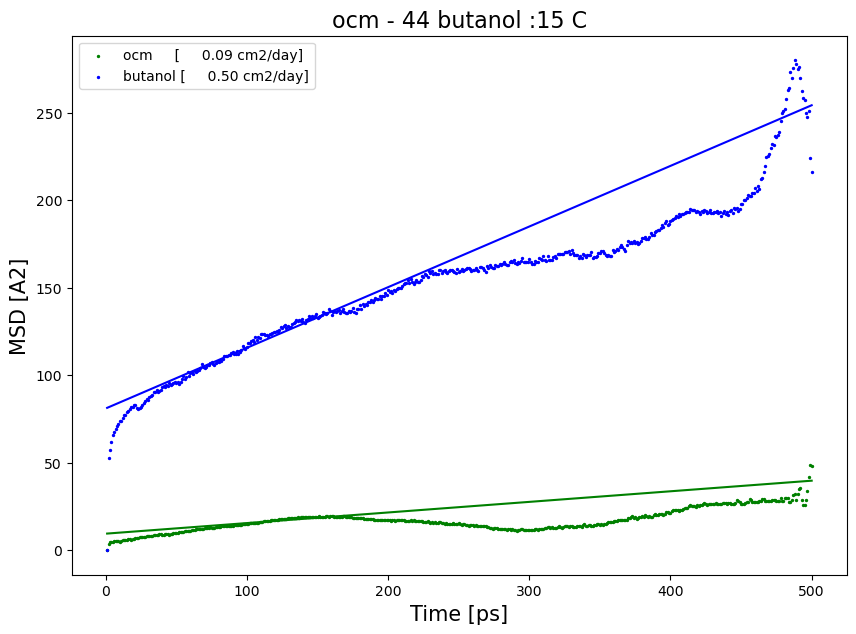

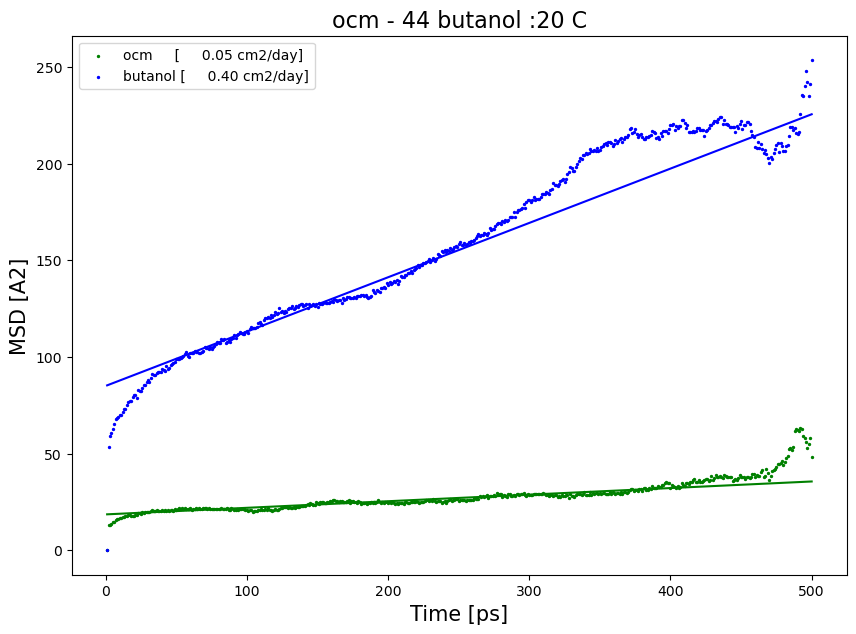

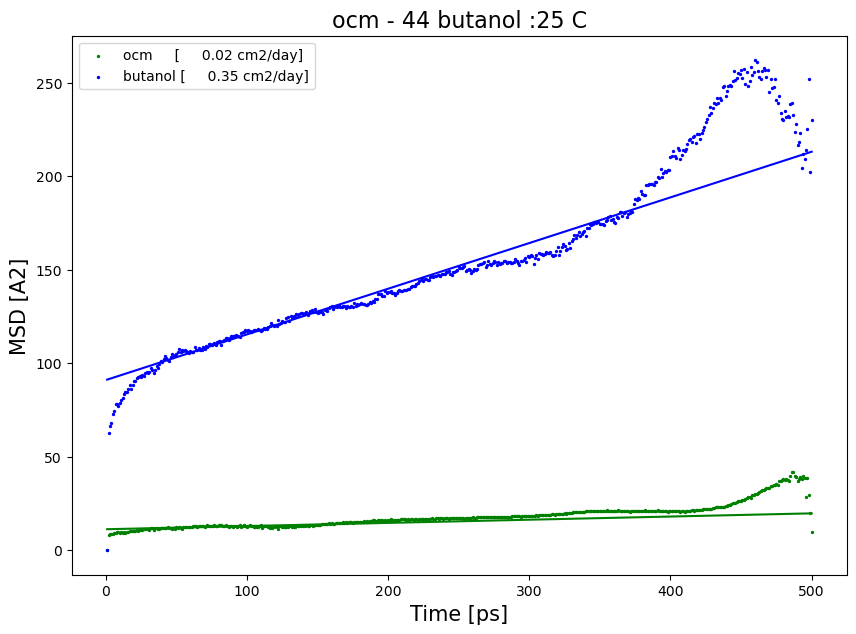

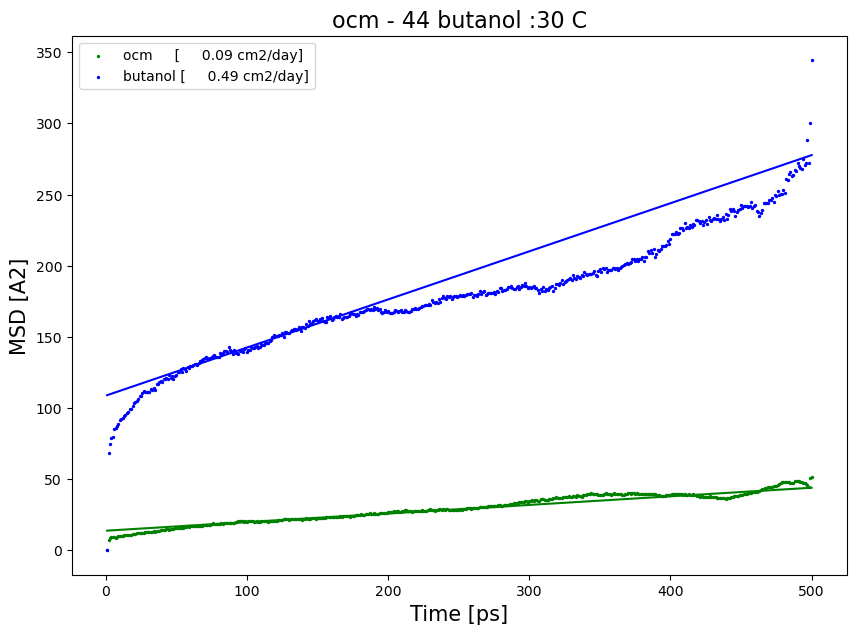

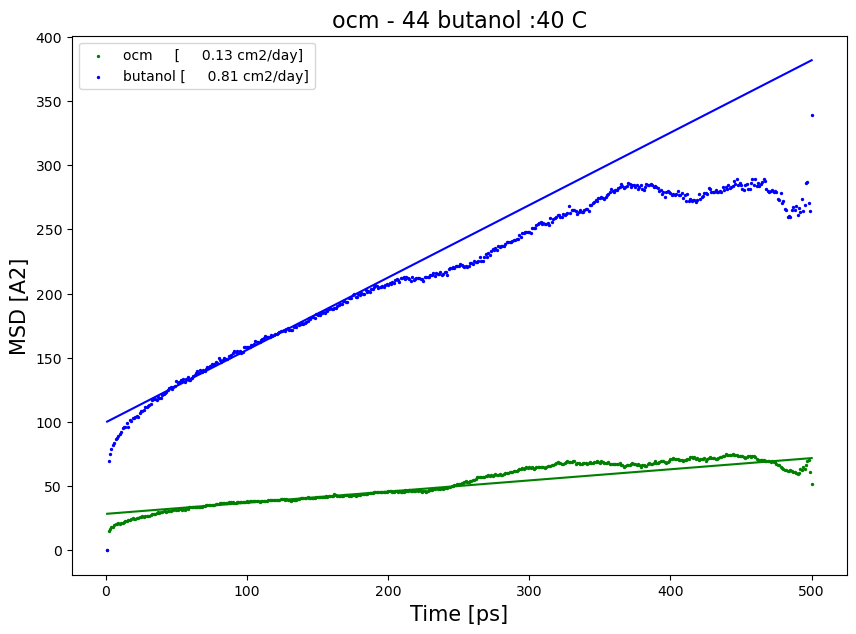

In [209]:
datas = []
for directory in get_solve_dir(solves_path):
    compound, x, rho = directory.parent.stem.split('_')
    T = directory.stem
    pdb = directory / pdb_name
    traj = directory / traj_name

    u = mda.Universe(pdb, traj)

    x_scaller, y_scaller = 1e12, 1e16
    df = get_MSD(u, Mols[compound])
    S, S0 = regress(strict(df))
    D = S / 6 * 24 * 60 * 60

    df_but = get_MSD(u, Mols.butanol)
    S_but, S0_but = regress(strict(df_but))
    D_but = S_but / 6 * 24 * 60 * 60

    fig, ax = plt.subplots()
    ax.set_ylabel('MSD [A2]')
    ax.set_xlabel('Time [ps]')

    time = df['Time']

    ax.scatter(
        time * x_scaller,
        df.iloc[:, 1] * y_scaller,
        label=f'{compound:7} [{D: 9.2f} cm2/day]',
        c='g',
        s=2,
    )

    time_but = df_but['Time']
    ax.plot(time * x_scaller, (S * time + S0) * y_scaller, 'g')
    ax.scatter(
        time_but * x_scaller,
        df_but.iloc[:, 1] * y_scaller,
        label=f'butanol [{D_but: 9.2f} cm2/day]',
        c='b',
        s=2,
    )
    ax.plot(time_but * x_scaller, (S_but * time_but + S0_but) * y_scaller, 'b-')
    ax.legend()

    ax.set_title(f"{compound} - {x} butanol :{T} C")
    Path(plots_path).mkdir(parents=True, exist_ok=True)
    fig.savefig(Path(plots_path) / f"{compound}_{x}_{T}.jpg", dpi=600)

    datas.append(
        {
            'compound': compound,
            'x': int(x),
            'Temperature': int(T),
            'D_comp': D,
            'D_but': D_but,
        }
    )
D_df = pd.DataFrame(datas)
D_df.to_csv(Path(plots_path).parent/'res.csv')

# D analyse

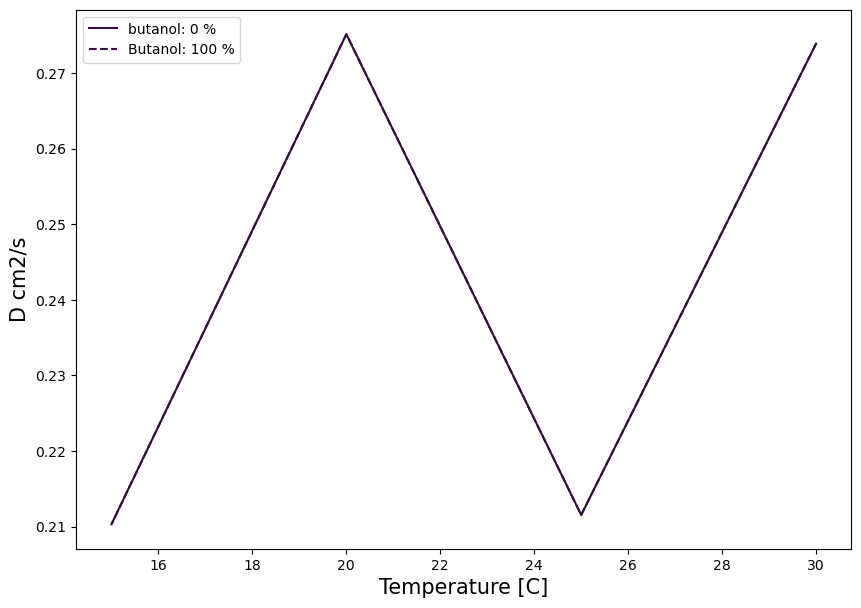

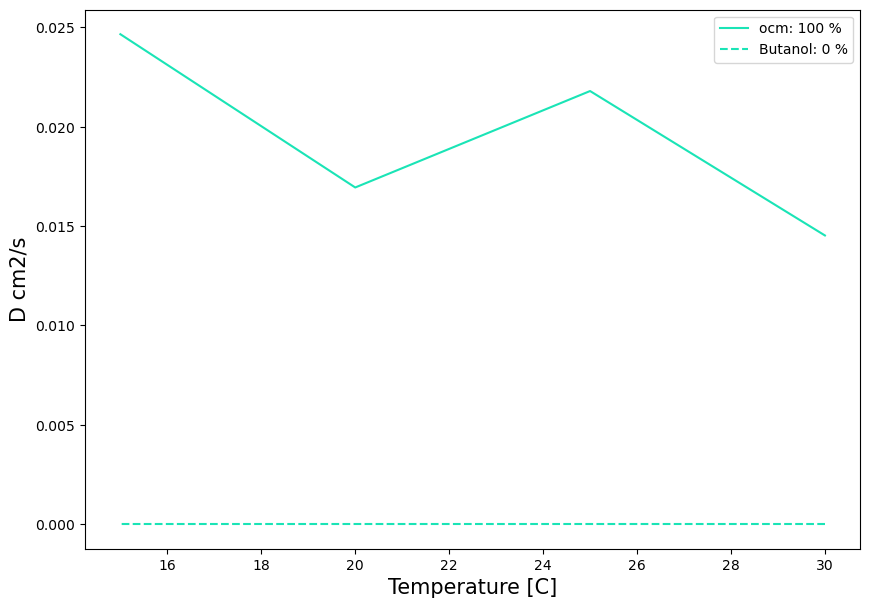

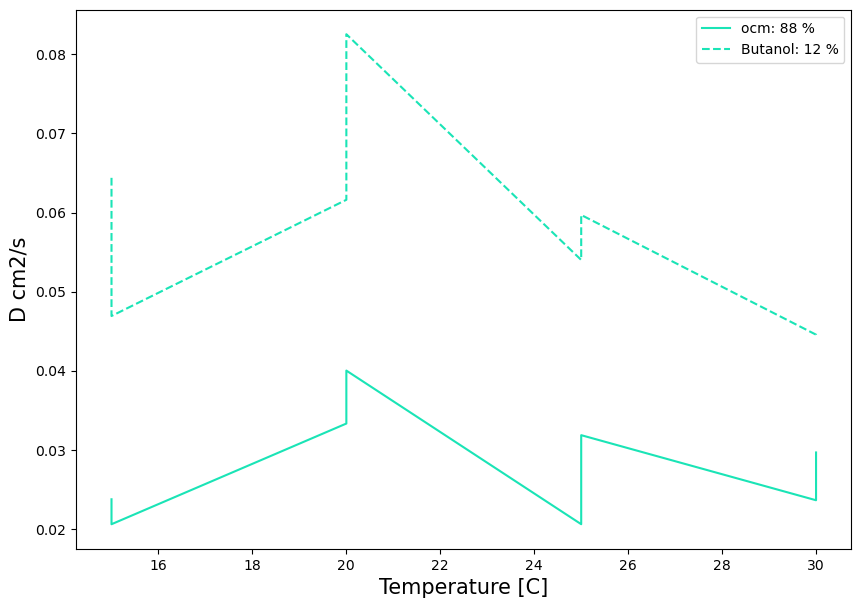

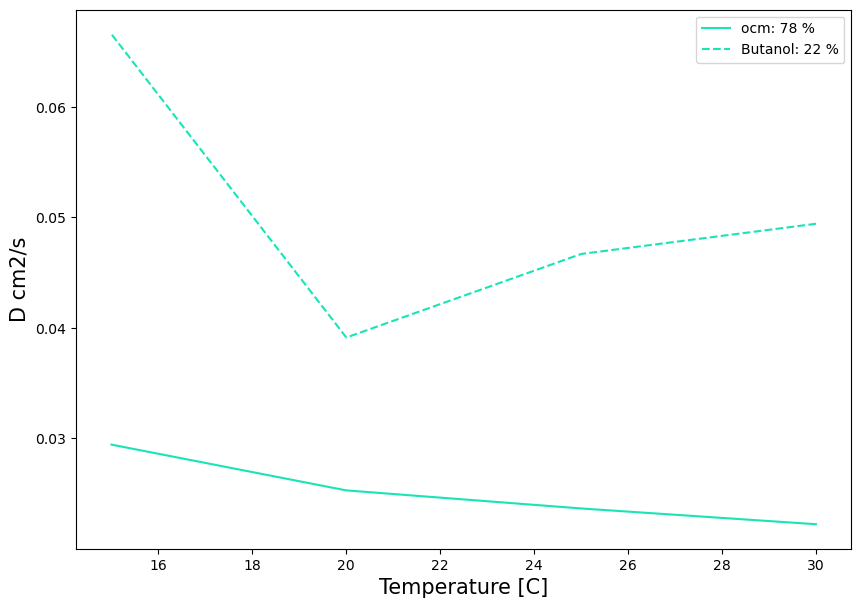

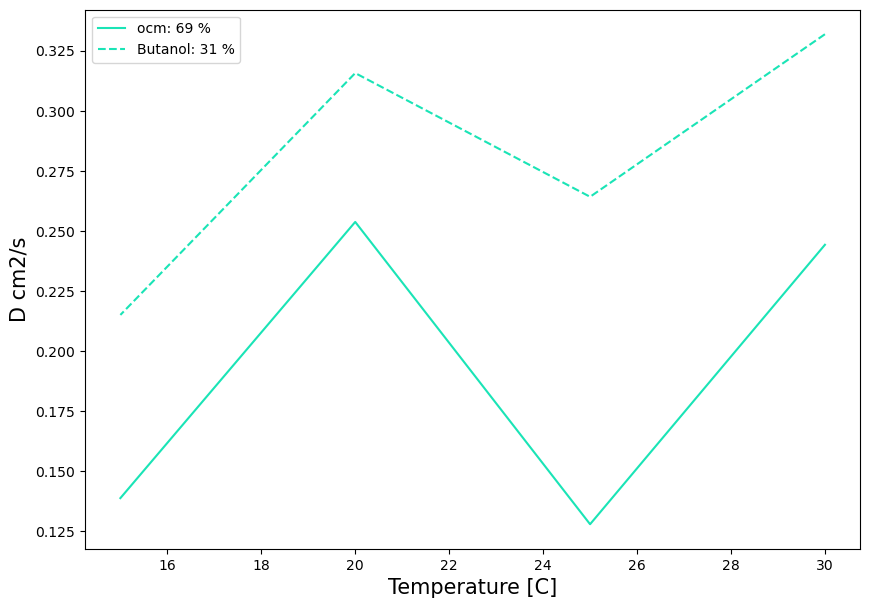

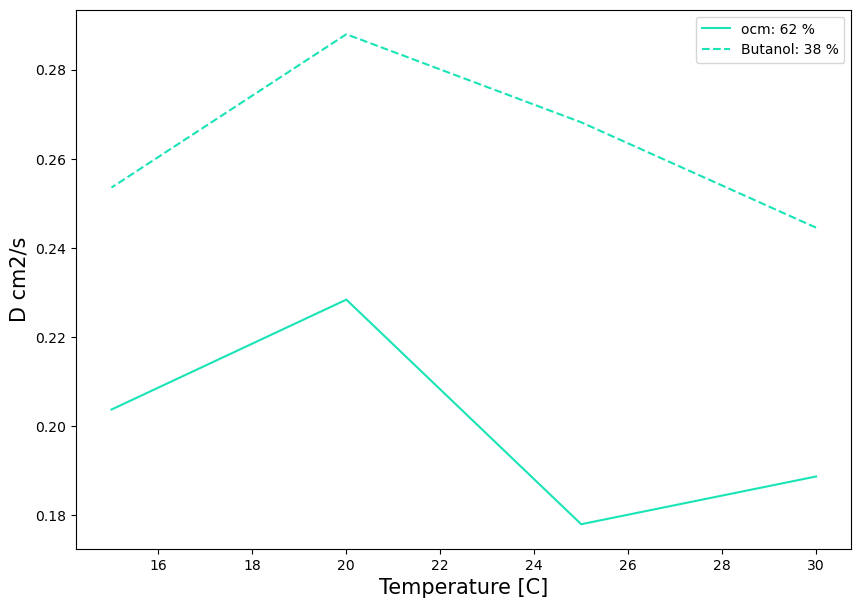

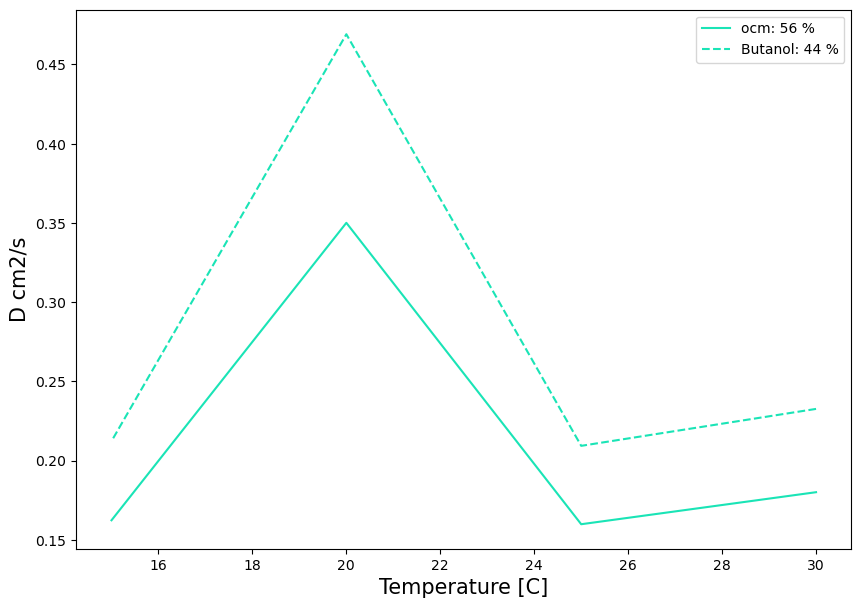

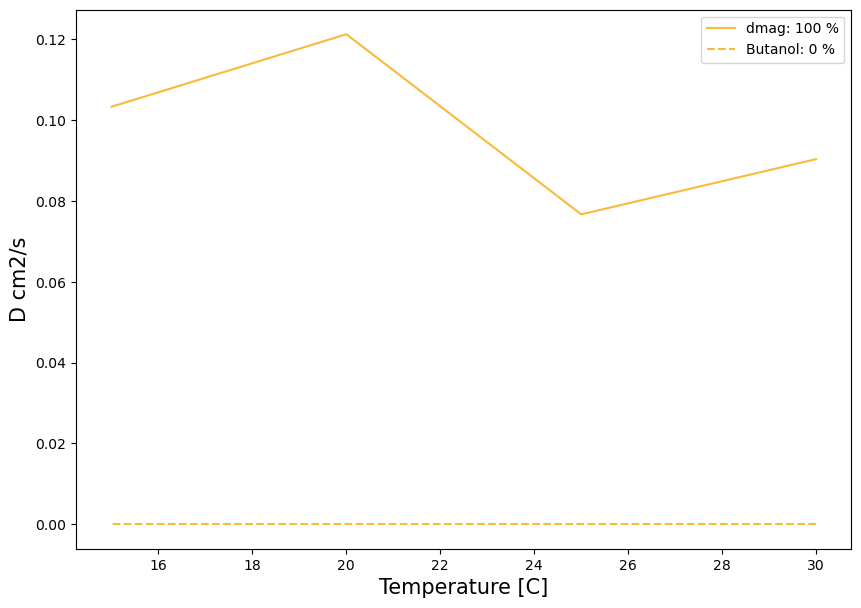

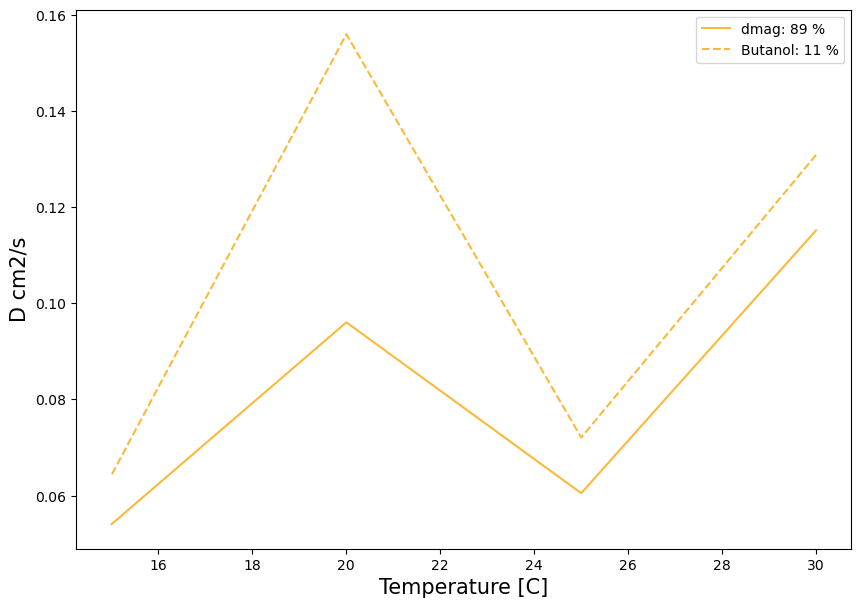

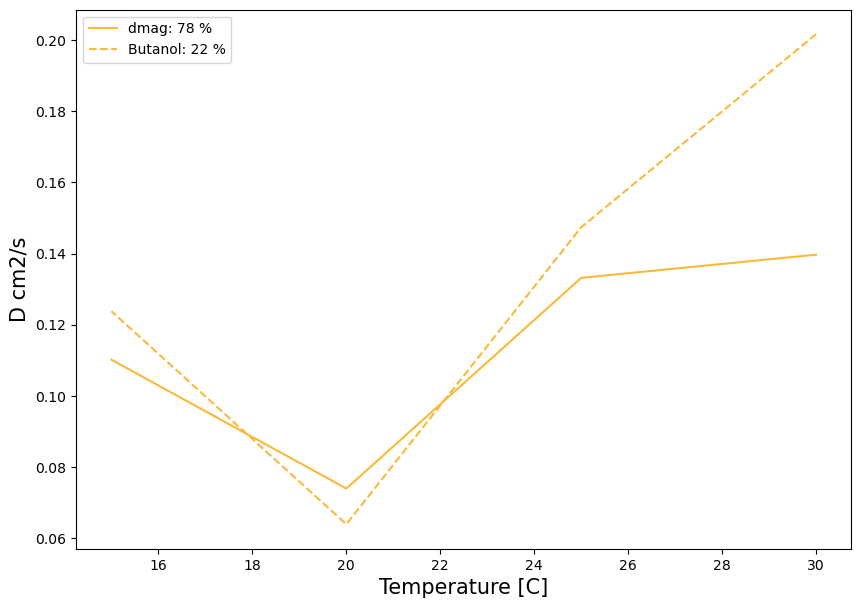

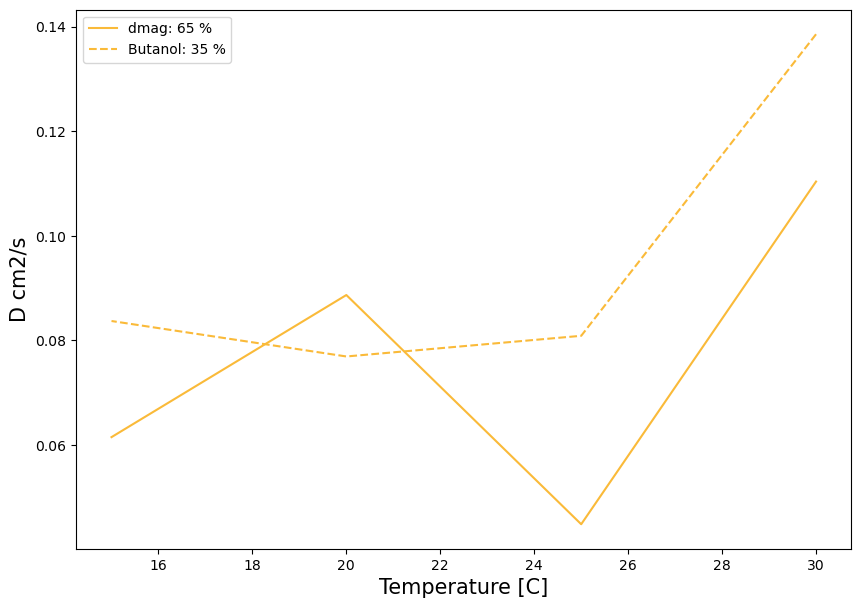

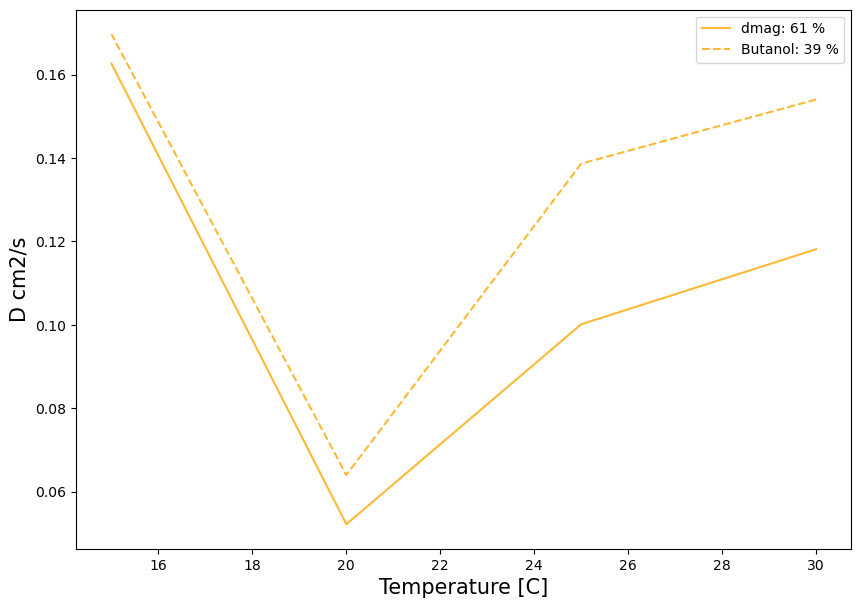

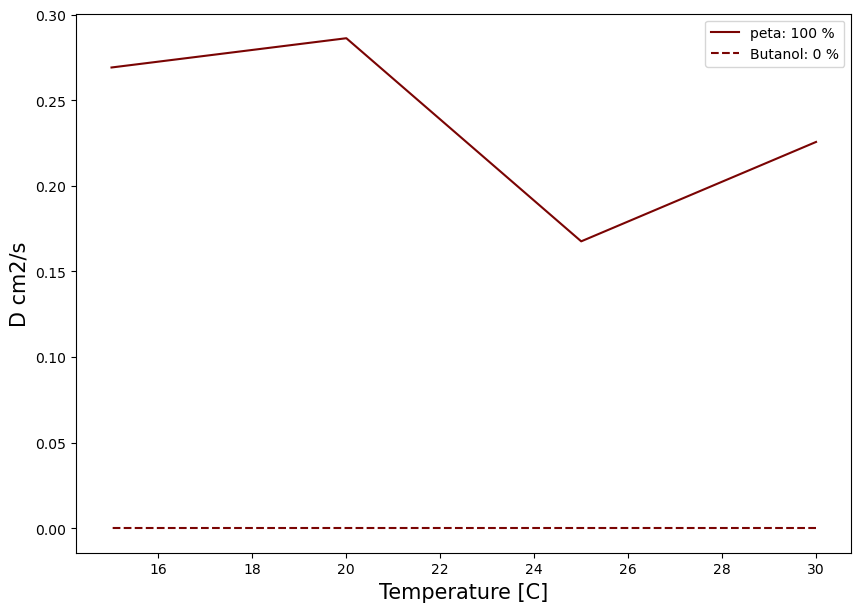

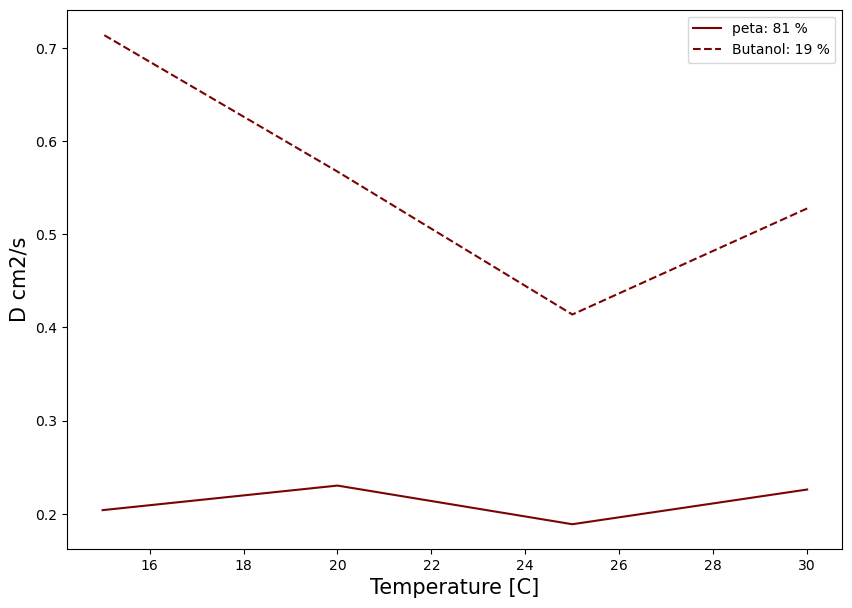

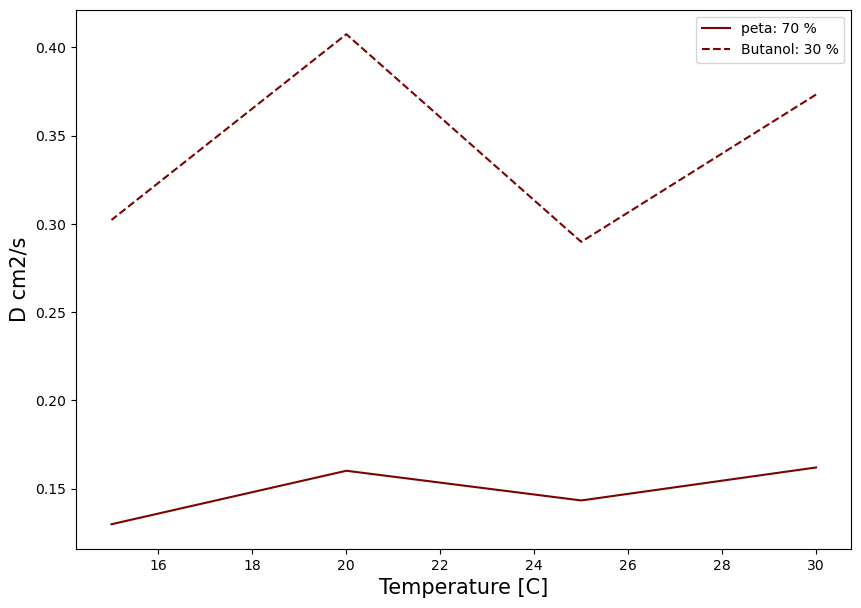

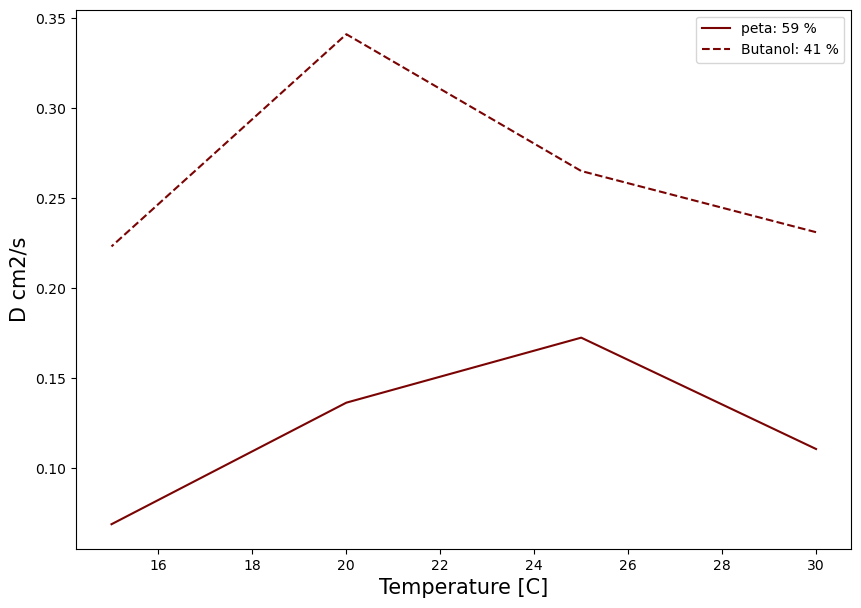

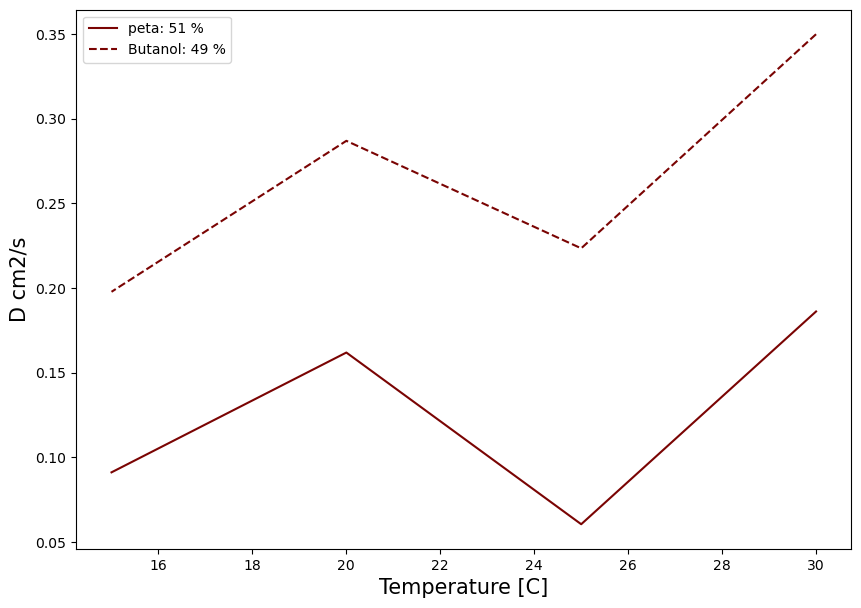

In [207]:
# D
colors_list = mcp.gen_color(
    cmap="turbo",
    n=len(D_df['compound'].unique()),
)
i = 0
for compound in Mols:
    df_sub = D_df[D_df['compound'] == compound.name]
    if len(df_sub) == 0:
        continue

    # fig, ax = plt.subplots(num="DT")

    for [x], df in df_sub.groupby(by=['x']):
        fig, ax = plt.subplots(num="DT")
        data_x = df.sort_values(by=['Temperature'], ascending=False)
        ax.plot(
            data_x['Temperature'],
            data_x['D_comp'],
            label=f"{compound.name}: {100-x} %",
            c=colors_list[i],
        )
        ax.plot(
            data_x['Temperature'],
            data_x['D_but'],
            linestyle='dashed',
            label=f"Butanol: {x} %",
            c=colors_list[i],
        )

        ax.set_xlabel("Temperature [C]")
        ax.set_ylabel("D cm2/s")
        ax.legend()
        plt.show()
    i += 1